# BEAST Analysis Notebook

---

# 0. SETUP

In [1]:
import os
import pandas as pd
import seaborn as sns
from Bio import Phylo, AlignIO
from functions import *
import subprocess
from matplotlib import colors
import matplotlib.pyplot as plt
import statsmodels.api as sma
import matplotlib.ticker as ticker
import statistics
import scipy

## Paths

In [2]:
WILDCARDS = ["all", "chromosome", "clade", "5"]
project_dir = "/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main/"
results_dir = project_dir

READS_ORIGIN = WILDCARDS[0]
LOCUS_NAME = WILDCARDS[1]
PRUNE = WILDCARDS[2]
MISSING_DATA = WILDCARDS[3]

In [3]:
# Phylogeography
#tree_dir            = project_dir + "/beast/all/chromosome/{}/phylogeography/".format(PRUNE)
# Clock
tree_dir            = project_dir + "/beast/all/chromosome/clade/tree"
log_dir             = project_dir + "/beast/all/chromosome/clade/log"

divtree_path        = project_dir + "iqtree/all/chromosome/full/filter5/filter-taxa/iqtree.treefile"
#metadata_path       = project_dir + "/iqtree/all/chromosome/full/filter{}/filter-taxa/metadata.tsv".format(MISSING_DATA)
metadata_path       = project_dir + "/iqtree_stats/all/chromosome/full/filter{}/metadata.tsv".format(MISSING_DATA)
auspice_config_path = project_dir + "/config/auspice_config.json"

# ------------------------------------------
# Alignment
constant_sites_path = project_dir + "/snippy_multi/all/chromosome/full/snippy-multi.constant_sites.txt".format(PRUNE)
aln_path            = project_dir + "iqtree/all/chromosome/full/filter{}/filter-clades/1.ORI/1.ORI.fasta".format(MISSING_DATA)

# ------------------------------------------
# Output
auspice_dir = os.path.join(results_dir, "auspice/all/chromosome/full/filter{}/beast/clock/".format(MISSING_DATA))
if not os.path.exists(auspice_dir):
    subprocess.run(["mkdir", "-p", auspice_dir]) 
    
augur_dir = os.path.join(results_dir, "augur/all/chromosome/full/filter{}/beast/clock/".format(MISSING_DATA))
if not os.path.exists(augur_dir):
    subprocess.run(["mkdir", "-p", augur_dir]) 

## Variables

In [4]:
pd.set_option("display.max_rows", 10, "display.max_columns", None)

# ------------------------------------------
BRANCH_LIST = {
    "1.ORI" : ["1.ORI1", "1.ORI2", "1.ORI3"],
    "1.IN": ["1.IN1","1.IN2","1.IN3"],  
    "1.ANT": ["1.ANT1"], 
    "1.PRE" : ["1.PRE0","1.PRE1", "1.PRE2", "1.PRE3"],
    "2.MED": ["2.MED0", "2.MED1","2.MED2","2.MED3" ],      
    "2.ANT": ["2.ANT1","2.ANT2","2.ANT3" ],    
    "4.ANT": ["4.ANT1" ],       
    "3.ANT": ["3.ANT1", "3.ANT2" ],  
    "0.ANT4" : ["0.ANT4"],     
    "0.ANT": ["0.ANT1", "0.ANT2","0.ANT3","0.ANT5"],         
    "0.PE": ["0.PE2", "0.PE4m", "0.PE4m", "0.PE4t", "0.PE4a", "0.PE5", "0.PE7", "0.PE8", "0.PE10"],   
    "0.PRE": ["0.PRE1", "0.PRE2"],    
}
BRANCH_LIST_REVERSE = list(BRANCH_LIST.keys())
BRANCH_LIST_REVERSE.reverse()
population_list = list(BRANCH_LIST.keys())

NO_DATA_CHAR = "NA"
JSON_INDENT=2
CURRENT_YEAR = 2021

# ------------------------------------------
# Alignment
with open(constant_sites_path) as infile:
    data = infile.read().strip().split(",")
    constant_sites = sum([int(count) for count in data])

aln = AlignIO.read(aln_path, "fasta")
variant_sites = len(aln[0].seq)
SEQ_LEN = constant_sites + variant_sites

NO_DATA_CHAR = "NA"
UNKNOWN_CHAR = "?"

POSTERIOR_THRESH = 95
BURNIN = 0.1

# ------------------------------------------
# Plotting
plt.rcParams['axes.facecolor']    ='white'
plt.rcParams['savefig.facecolor'] ='white'
plt.rcParams['savefig.dpi']       = 400
plt.rcParams['svg.fonttype']      = 'none'

---

# 1. IMPORT

## Metadata

In [5]:
metadata_df = pd.read_csv(metadata_path, sep='\t')
metadata_df.set_index(metadata_df.columns[0], inplace=True)
metadata_df.fillna(NO_DATA_CHAR, inplace=True)

display(metadata_df)

,strain,date,date_bp,country,province,country_lat,country_lon,province_lat,province_lon,biovar,branch_major,branch_minor,biosample_accession,biosample_comment,branch_number,continent,date_mean,date_bp_mean,date_err,lat,lon,host_human,sequencing_technology,assembly_method,host_raw,host_order,population_color,population,geometry,root_rtt_dist,clade_rtt_dist,population_rtt_dist,tstv,cds_sites,ns_sites,ss_sites,ns_ss_ratio,other_var,other_var_ratio,homo_het_sites,homo_sites,het_sites,het_ratio,external_branch_length,variant_qc,tstv_outlier
sample,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
Reference,CO92,1992,-29,United States of America,Colorado,39.783730,-100.445882,38.7252,-105.608,Orientalis,1.ORI,1.ORI1,SAMEA1705942,KEEP: Assembly Modern Reference,1,North America,1992.0,29.0,0.0,38.725178,-105.607716,Human,NA,NA,Human,Human,#ff0000,1.ORI,POINT (-105.607716 38.7251776),0.000073,NA,0.000006,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,NA,4.004600e-06,pass,0.0
GCA_009909635.1_ASM990963v1_genomic,9_10,1923.0,-98,Russia,Rostov Oblast,64.686314,97.745306,47.6222,40.7958,Medievalis,2.MED,2.MED1,SAMN13632815,KEEP: Assembly Modern,2,Europe,1923.0,98.0,0.0,47.622245,40.795794,Human,IonTorrent,Newbler v. 2.6,Homo sapiens,Human,#c5e88a,2.MED,POINT (40.7957942 47.6222451),0.000073,NA,0.000010,1.854,216,121,51,2.37255,1,0.0196078,242,216,26,0.107438,2.120100e-06,pass,0.0
GCA_009669545.1_ASM966954v1_genomic,42126,2006.0,-15,China,Xinjiang,35.000074,104.999927,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722925,KEEP: Assembly Modern,0,Asia,2006.0,15.0,0.0,42.480495,85.463346,Non-Human,Illumina Hiseq 2000,SOAPdenovo v. 2.04,Citellus undulatus,Rodentia,#238af5,0.ANT,POINT (85.46334640000001 42.4804953),0.000054,NA,0.000012,1.935,246,134,60,2.23333,0,0,271,246,25,0.0922509,0.000000e+00,pass,0.0
GCA_009669555.1_ASM966955v1_genomic,42123,2005.0,-16,China,Xinjiang,35.000074,104.999927,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722924,KEEP: Assembly Modern,0,Asia,2005.0,16.0,0.0,42.480495,85.463346,Non-Human,Illumina Hiseq 2000,SOAPdenovo v. 2.04,Frontopsylla elatoides,Siphonaptera,#238af5,0.ANT,POINT (85.46334640000001 42.4804953),0.000055,NA,0.000012,2.119,241,133,58,2.2931,0,0,258,241,17,0.0658915,2.356000e-07,pass,0.0
GCA_009669565.1_ASM966956v1_genomic,42118,2005.0,-16,China,Xinjiang,35.000074,104.999927,42.4805,85.4633,Antiqua,0.ANT,0.ANT1,SAMN07722923,KEEP: Assembly Modern,0,Asia,2005.0,16.0,0.0,42.480495,85.463346,Non-Human,Illumina Hiseq 2000,SOAPdenovo v. 2.04,Citellus undulatus,Rodentia,#238af5,0.ANT,POINT (85.46334640000001 42.4804953),0.000055,NA,0.000012,2,247,135,60,2.25,0,0,265,247,18,0.0679245,4.711000e-07,pass,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SAMEA7313243_45,Azov38,[1400:1700],[-621:-321],Russia,Rostov Oblast,64.686314,97.745306,47.6222,40.7958,Second Pandemic,1.PRE,1.PRE1,SAMEA7313243_45,KEEP: SRA Ancient Combined Record,1,Europe,1550.0,471.0,150.0,47.622245,40.795794,Human,NextSeq 500,NA,Homo sapiens,Human,#f3c16a,1.PRE,POINT (40.7957942 47.6222451),0.000075,NA,0.000022,1.917,96,48,28,1.71429,3,0.107143,120,96,24,0.2,1.202300e-06,pass,0.0
SAMEA7313246_49,Gdansk8,[1400:1700],[-621:-321],Poland,Pomeranian Voivodeship,52.215933,19.134422,54.2456,18.1099,Second Pandemic,1.PRE,1.PRE1,SAMEA7313246_49,KEEP: SRA Ancient Combined Record,1,Europe,1550.0,471.0,150.0,54.245560,18.109900,Human,NextSeq 500,NA,Homo sapiens,Human,#f3c16a,1.PRE,POINT (18.1099 54.24556),0.000060,NA,0.000007,1.813,171,74,45,1.64444,17,0.377778,260,171,89,0.342308,5.131000e-07,pass,0.0
SAMEA6651390,AGU010,[1435:1477],[-586:-544],Lithuania,Vilnius County,55.350000,23.750000,54.8227,25.2495,Second Pandemic,1.PRE,1.PRE1,SAMEA6651390,KEEP: SRA Ancient,1,Europe,1456.0,565.0,21.0,54.822692,25.249534,Human,NextSeq 500,NA,Homo sapiens,Human,#f3c16a,1.PRE,POINT (25.24953400167952 54.82269205),0.000060,NA,0.000006,2.378,138,72,40,1.8

## Most Recent Sampling Date

In [6]:
out_path = os.path.join(augur_dir, "most_recent_sampling_dates.tsv")
mrsd_dict = {}

with open(out_path, "w") as outfile:
    for population in population_list:
        pop_df = metadata_df[metadata_df["population"] == population]
        if len(pop_df) == 0: continue
        max_date = max(pop_df["date_mean"])
        outfile.write("{}\t{}\n".format(population, max_date))
        mrsd_dict[population] = max_date
        
print(mrsd_dict)

{'1.ORI': 2016.0, '1.IN': 2008.0, '1.ANT': 2004.0, '1.PRE': 1767.5, '2.MED': 2018.0, '2.ANT': 2008.0, '4.ANT': 2015.0, '3.ANT': 2017.0, '0.ANT4': 765.0, '0.ANT': 2019.0, '0.PE': 2014.0, '0.PRE': -1686.0}


## Sampling Date Range

In [7]:
out_path = os.path.join(augur_dir, "range_sampling_dates.tsv")
print(out_path)
with open(out_path, "w") as outfile:
    outfile.write("{}\t{}\t{}\t{}\t{}\t{}\n".format("population", "n", "min_date", "max_date", "range_date", "range_n"))
    for population in population_list:
        pop_df = metadata_df[metadata_df["population"] == population]
        if len(pop_df) == 0: continue
        n = len(pop_df)
        max_date = max(pop_df["date_mean"])
        min_date = min(pop_df["date_mean"])
        range_date = max_date - min_date
        range_n = round(range_date / n, 2)
        print(population, min_date, max_date, range_date)
        outfile.write("{}\t{}\t{}\t{}\t{}\t{}\n".format(population, n, min_date, max_date, range_date, range_n))

/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main/augur/all/chromosome/full/filter5/beast/clock/range_sampling_dates.tsv
1.ORI 1924.0 2016.0 92.0
1.IN 1954.0 2008.0 54.0
1.ANT 1954.0 2004.0 50.0
1.PRE 1330.0 1767.5 437.5
2.MED 1912.0 2018.0 106.0
2.ANT 1924.0 2008.0 84.0
4.ANT 1977.0 2015.0 38.0
3.ANT 1961.0 2017.0 56.0
0.ANT4 237.5 765.0 527.5
0.ANT 1947.0 2019.0 72.0
0.PE -1836.0 2014.0 3850.0
0.PRE -2776.5 -1686.0 1090.5


## Colors

In [8]:
out_path_colors = os.path.join(augur_dir, "colors.tsv")
attributes = ["country", "province","continent", "host_order"]
colors_dict = {}

colors_dict["population"] = {'0.PRE': '#8000ff', '0.PE': '#5148fc', '0.ANT': '#238af5', '0.ANT4': '#0cc1e8', '3.ANT': '#3ae8d7', '4.ANT': '#68fcc1', '2.ANT': '#97fca7', '2.MED': '#c5e88a', '1.PRE': '#f3c16a', '1.ANT': '#ff8a48', '1.IN': '#ff4824', '1.ORI': '#ff0000', 'NA': '#c4c4c4'}
colors_dict["population"]["prune"] = "#c4c4c4"

for attr in attributes:
    # Create the color map
    colors_dict[attr] = {}
    
    states = set(metadata_df[attr])
        
    # Create the custom color map (pyplot)
    cmap = plt.get_cmap("rainbow", len(states))
    # Convert the color map to a list of RGB values
    cmaplist = [cmap(i) for i in range(cmap.N)]
    # Convert RGB values to hex colors
    attr_hex = [colors.to_hex(col) for col in cmaplist]

    # Assign colors to value
    for state, color in zip(states, attr_hex):
        colors_dict[attr][state] = color
        
    # Add unknown
    colors_dict[attr][NO_DATA_CHAR] = "#969696"
    
print(colors_dict)

with open(out_path_colors, "w") as outfile:
    for attr_key in colors_dict:
        for attr_val in colors_dict[attr_key]:
            outfile.write(str(attr_key) + "\t" + str(attr_val) + "\t" + str(colors_dict[attr_key][attr_val]) + "\n")        

{'population': {'0.PRE': '#8000ff', '0.PE': '#5148fc', '0.ANT': '#238af5', '0.ANT4': '#0cc1e8', '3.ANT': '#3ae8d7', '4.ANT': '#68fcc1', '2.ANT': '#97fca7', '2.MED': '#c5e88a', '1.PRE': '#f3c16a', '1.ANT': '#ff8a48', '1.IN': '#ff4824', '1.ORI': '#ff0000', 'NA': '#c4c4c4', 'prune': '#c4c4c4'}, 'country': {'Democratic Republic of the Congo': '#8000ff', 'Italy': '#7215ff', 'Iran': '#652afe', 'Georgia': '#573ffd', 'Armenia': '#4a53fc', 'Turkmenistan': '#3c66fa', 'Lithuania': '#2f79f7', 'Uganda': '#228bf4', 'Algeria': '#149df1', 'United States of America': '#07adee', 'Zimbabwe': '#07bcea', 'Kenya': '#14c9e5', 'Madagascar': '#22d5e0', 'France': '#2fe0db', 'Norway': '#3cead5', 'Vietnam': '#4af1d0', 'Poland': '#57f7c9', 'Kyrgyzstan': '#65fcc3', 'Switzerland': '#72febc', 'Mongolia': '#80ffb4', 'Nepal': '#8dfead', 'Estonia': '#9afca5', 'China': '#a8f79d', 'Azerbaijan': '#b5f194', 'The Netherlands': '#c3ea8b', 'Brazil': '#d0e083', 'Spain': '#ddd579', 'Indonesia': '#ebc970', 'Myanmar': '#f8bc66', '

## Latitude and Longitude

In [9]:
latlon_country_df = pd.DataFrame()
latlon_province_df = pd.DataFrame()

df_list = [latlon_country_df, latlon_province_df]
attr_list = ["country", "province"]

# Create a mapping of geo name to lat,lon
for df,attr in zip(df_list, attr_list):
    # Get data
    for rec in metadata_df.iterrows():
        node_name = rec[0]
        name = rec[1][attr]
        country = rec[1]["country"]
        
        #node_type = rec[1]["node_type"]
        #if node_type == "internal":
        #    continue

        #if attr == "province" and name == NO_DATA_CHAR and node_type == "terminal" and country != "Russia":
        if attr == "province" and name == NO_DATA_CHAR and country != "Russia":
            # Use country instead
            name = rec[1]["country"]
            lat = rec[1]["country_lat"]
            lon = rec[1]["country_lon"]
        else:
            lat = rec[1][attr + "_lat"]
            lon = rec[1][attr + "_lon"]             


        if name not in df.index:
            df.at[name, "lat"] = lat
            df.at[name, "lon"] = lon
            df.at[name, "size"] = 1
        else:
            df["size"][name] += 1
        

#display(latlon_country_df)
#display(latlon_province_df)

# Mapping file for auspice
out_path_latlon = os.path.join(augur_dir, "latlon.tsv")

# Countries
with open(out_path_latlon, "w") as outfile:
    for country in latlon_country_df.index:
        lat = str(latlon_country_df["lat"][country])
        lon = str(latlon_country_df["lon"][country])
        outfile.write("country" + "\t" + country + "\t" + lat + "\t" + lon + "\n")
# Provinces
with open(out_path_latlon, "a") as outfile:
    for province in latlon_province_df.index:
        lat = str(latlon_province_df["lat"][province])
        lon = str(latlon_province_df["lon"][province])
        outfile.write("province" + "\t" + province + "\t" + lat + "\t" + lon + "\n")
        
#display(metadata_df[metadata_df["continent"] == "Europe"])

## Continent

In [10]:
continent_dict = {}

for rec in metadata_df.iterrows():
    continent = rec[1]["continent"]
    country = rec[1]["country"]
    continent_dict[country] = continent

## Tree Files

In [11]:
divtree = Phylo.read(divtree_path, "newick")
divtree.ladderize(reverse=False)

# Rename internal nodes      
node_i = 0
for c in divtree.find_clades():
    if not c.name or "NODE" in c.name:
        c.name = "NODE{}".format(node_i)
        node_i += 1

Population: 1.ORI
Rename: GCA_000986995.1_YPES001_SEQ_2_ASM_1_genomic_22 GCA_000986995.1_YPES001-SEQ-2-ASM-1_genomic_22
Rename: GCA_000324805.2_EV76_CN_genomic_90 GCA_000324805.2_EV76-CN_genomic_90


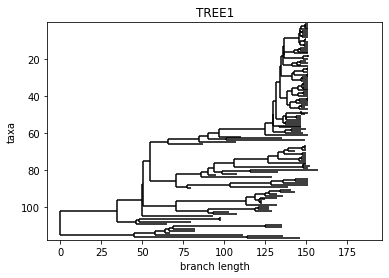

Population: 1.IN


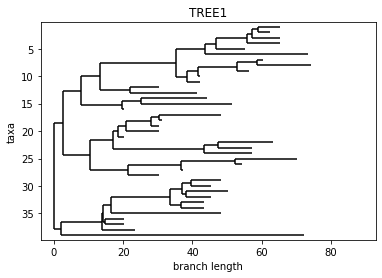

Population: 1.ANT


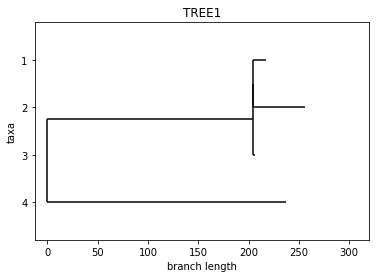

Population: 1.PRE


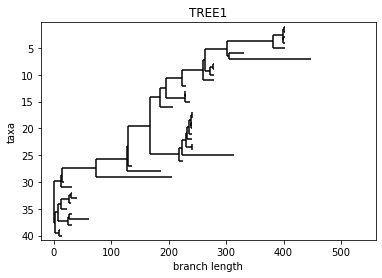

Population: 2.MED
Rename: GCA_001617705.1_Yersinia_pestis_C_791_genomic_15 GCA_001617705.1_Yersinia_pestis_C-791_genomic_15
Rename: GCA_001617815.1_Yersinia_pestis_M_1453_genomic_27 GCA_001617815.1_Yersinia_pestis_M-1453_genomic_27
Rename: GCA_001617715.1_Yersinia_pestis_M_519_genomic_51 GCA_001617715.1_Yersinia_pestis_M-519_genomic_51
Rename: GCA_001617725.1_Yersinia_pestis_M_1484_genomic_26 GCA_001617725.1_Yersinia_pestis_M-1484_genomic_26
Rename: GCA_001617785.1_Yersinia_pestis_M_549_genomic_41 GCA_001617785.1_Yersinia_pestis_M-549_genomic_41
Rename: GCA_002412305.1_Y.pestis_A_1809_genomic_38 GCA_002412305.1_Y.pestis_A-1809_genomic_38
Rename: GCA_001617735.1_Yersinia_pestis_M_1763_genomic_16 GCA_001617735.1_Yersinia_pestis_M-1763_genomic_16


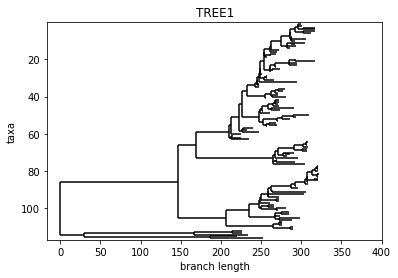

Population: 2.ANT


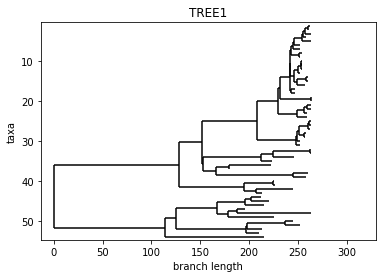

Population: 4.ANT


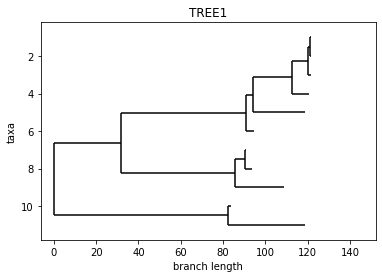

Population: 3.ANT


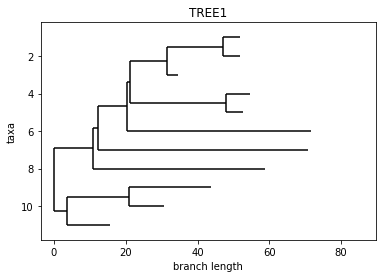

Population: 0.ANT4


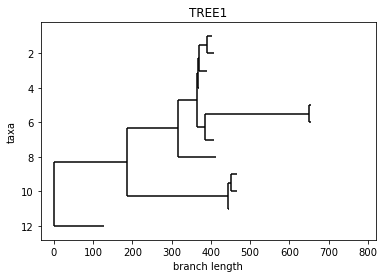

Population: 0.ANT
Rename: GCA_002412225.1_Y.pestis_A_1486_genomic_53 GCA_002412225.1_Y.pestis_A-1486_genomic_53
Rename: GCA_002412255.1_Y.pestis_A_1836_genomic_36 GCA_002412255.1_Y.pestis_A-1836_genomic_36
Rename: GCA_002412245.1_Y.pestis_A_1691_genomic_48 GCA_002412245.1_Y.pestis_A-1691_genomic_48


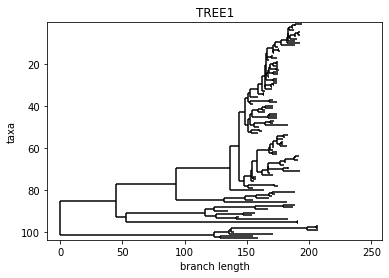

Population: 0.PE
Rename: GCA_002412235.1_Y.pestis_A_1249_genomic_44 GCA_002412235.1_Y.pestis_A-1249_genomic_44
Rename: GCA_003122795.1_Y.pestis_I_2422_genomic_40 GCA_003122795.1_Y.pestis_I-2422_genomic_40


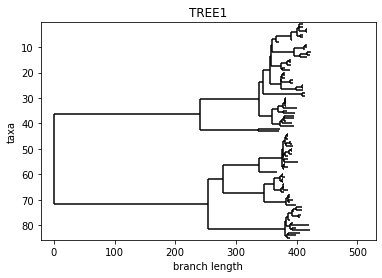

Population: 0.PRE


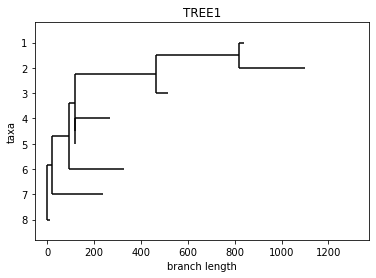

In [12]:
# Construct a dictionary to hold the trees
tree_dict = {}

for population in ["prune"] + population_list:
    for filename in os.listdir(tree_dir):
        if not filename.endswith(".tree") and not filename.endswith(".tre"): continue
        # For clock model 
        if "clade/phylogeography" not in tree_dir and "UCLN" not in filename: continue
            
        filepath = os.path.join(tree_dir, filename)
        
        # Check file matches population
        filename_strip = filename.split("_")[0].replace("SC","").replace("UCLN","")
        if filename_strip == population:
        
            print("Population:", population)
            tree_dict[population] = {}  
            
            # Add tree files to dict
            tree_dict[population]["tree_file_raw"] = filepath 
            tree_dict[population]["tree_file_edit"] = os.path.join(tree_dir, population + ".nex")
            tree_dict[population]["sample_rename"] = {}
            
            # Read in raw tree to deal with dashes
            with open(tree_dict[population]["tree_file_raw"],  "r") as infile:                    
                with open(tree_dict[population]["tree_file_edit"], "w") as outfile:           
                    raw_tree = infile.read()
                    # Remove quotations if they exist
                    raw_tree = raw_tree.replace("'","")
                    
                    # Split into lines to iterate over
                    raw_tree_lines = raw_tree.split("\n")
                    
                    # By default don't parse a line for dashes
                    taxa_line = False
                    
                    for line in raw_tree_lines: 
                                
                        if "TREE" not in line and "-" in line:
                            
                            if len(line.split(" ")) == 1:
                                name_dashes = line.strip()
                                name_no_dashes = name_dashes.replace("-","_")
                                tree_dict[population]["sample_rename"][name_no_dashes] = name_dashes
                            line = line.replace("-","_")
                                
                        outfile.write(line + "\n")
            
            # Read in edited tree
            trees = Phylo.parse(tree_dict[population]["tree_file_edit"], "nexus")
            # There should be only 1 tree
            for t in trees:
                tree_dict[population]["tree"] = t
                tree_dict[population]["tree"].ladderize(reverse=True)
                break

            # Rename sample names back to with dashes
            for c in tree_dict[population]["tree"].find_clades():
                if c.name in tree_dict[population]["sample_rename"]:
                    orig_name = c.name
                    c.name = tree_dict[population]["sample_rename"][c.name]
                    print("Rename:", orig_name, c.name)
                    
                # Strip the date suffix
                if c.name:
                    c.name = "_".join(c.name.split("_")[0:-1]) 
                    
            # Write again
            outfile = tree_dict[population]["tree_file_edit"]
            Phylo.write(tree_dict[population]["tree"], outfile, "nexus")
            
                    
            # Rename internal nodes
            node_i = 0
            for c in tree_dict[population]["tree"].find_clades():
                if not c.name:
                    c.name = "NODE{}".format(node_i)
                    node_i += 1
    
    if population in tree_dict:
        Phylo.draw(tree_dict[population]["tree"], label_func = lambda x: '')    

---
# Branch Lengths

## External Branch Lengths

In [13]:
"""population_list = []

# Add external branch length
for tdata:image/png;base64,iVBORw0KGgoAAAANSUhEUgAABGUAAAMMCAYAAAD6thpCAAAAOXRFWHRTb2Z0d2FyZQBNYXRwbG90bGliIHZlcnNpb24zLjMuMiwgaHR0cHM6Ly9tYXRwbG90bGliLm9yZy8vihELAAAACXBIWXMAAB7CAAAewgFu0HU+AACNXklEQVR4nOzdeXzcdYH/8fcnd5q0aQ46PZJ2etEDCjS1aFWwoByuggii7k+qqKCrlVV0wVYEWhWoVmVdKe6udUXBVQ5BRFcOgSIioG05SltKr2nTtJk0R9MkzTFJPr8/vpM2TZM0x8z3k5m8no/HPJqZ+c583823R/LO5zDWWgEAAAAAAMBfKa4DAAAAAAAAjESUMgAAAAAAAA5QygAAAAAAADhAKQMAAAAAAOAApQwAAAAAAIADlDIAAAAAAAAOUMoAAAAAAAA4QCkDAAAAAADgAKUMAAAAAACAA5QyAAAAAAAADlDKAAAAAAAAOEApAwAAAAAA4AClDAAAAAAAgAOUMgAAAAAAAA5QygAAAAAAADhAKQMAAAAAAOAApQwAAAAAAIADlDIAAAAAAAAOUMoAAAAAAAA4QCkDAAAAAADgAKUMAGDYMcaMMsacb4z5hjHmf40xfzfG7DfGNBpj2qO/hqOP/9IY8yljTIGP+aYbY2wft0cH+H5X9/Fe+4wxmSd5/T29vPbqLsesOEnmwd5Cg/ssAgAAIM11AAAAenC/pA/28fyo6G2cpIWSlkhqMMb8QNK3rbXtcc531Umef78xptBaWx2Dc02S9HlJ/xGD9wIAAMAwwkgZAMBwZAbxmlxJt0p60BgzmNcPxCdO8ny6pI/F8HzLjTHZMXw/AAAADAOUMgCAZPNhSZ+K15sbY94uaWY/Dj3ZaJqBGC/pCzF8PwAAAAwDTF8CAAxXbZL+Iel5SVslVUhqkTdlaZ6kq+VN7enJZyTdE6dcS/p53CJjzHRr7c4Ynffrxpj/tNYeGeTr/0fSn/t4/v2SvtHD4xWSruzjdc2DzAMAADDiUcoAAIajOyV92lp7sJfn7zfG3C7pCUnv7uH50+IRyhiTJumjA3jJJyR9K0anHyfpS5K+N5gXW2v3Strb2/PGmBm9PNVirf3rYM4JAACAvjF9CQAw7Fhrn+6jkOk85oi88qYnubFPJUm6WNIpPTz+G0mtPTweyylMknSDMSZevzcAAAD4jFIGAJDIevt/bE+cztfb1KW1kp7q4fGZ0TVoBst2u18k6V+H8H4AAAAYRihlAAAJKbobUW8Fxe/jcL4xki7p4akqSeskPdjLS4cyWuYJSd3XkPlaNAsAAAASHKUMAGBYM8ZMM8a8O3pbbIy53BizUtJmSef08JIySXfEIcoVknralvoRa227pEclRXp4/mPRtWgGIyzp7m6PFUj6yiDfDwAAAMMIpQwAYLj7qrwdmJ6X9Kyk30q6RdLUHo79q6T3WGur45Cjt6lLD0qStfaQet7d6BRJFw3hvN+T1NDtseuNMWOH8J4AAAAYBihlAADJoE7SNdbac6y1u2P95saYSZLe08NT1fKKok4xn8IUXfD4rm4Pj5VXVgEAACCBUcoAAJJBnqS1xphHjTElcXj/T6jn/zN/Z61t63pfPU9h+pAxZvQQzr9aUn23x75sjCkYwnsCAADAMUoZAEAyuVTSemPMrBi/b28jXY4bGWOtrZX0TA/HZctbk2ZQrLU1kn7U7eExkv5tsO8JAAAA9yhlAADDmrX2S9ZaY601kjIlTZL0fkm/lNTRw0vGSfqNMcbE4vzGmDMlzevhqRr1XMDEYxcmSfqBvGlaXV1njCka4vsCAADAEUoZAEDCsNa2Wmv3W2sft9Z+StLHejn0LEnvi9FpeytTHrXW9jRV6XeS2np4/DxjzMTBhoguJHxnt4dzJd042PcEAACAW5QyAICEZa19SNKLvTx97lDf3xiTIun/9fL0p40xtvtNUpWknrbA7uu9+utOSbXdHlsqKTDE9wUAAIADlDIAgES3p5fHY1FUnC9p0KNbejCkKUzW2sPypjF1NUpD23IbAAAAjlDKAAASVnTdmDN7ebr7iJLBGOo6MN2daYw5fYjv8R/ytuLuKibr5wAAAMBflDIAgGHFGPMrY8xyY8yEkxxnJH1b0pxeDtnWw2uu7mnKkTFmRQ/HZku6fBC/hZNZMpQXW2vr5W2RDQAAgATX05x3AABcmiRv7ZXbjDEvSXpB0uuSKiU1Sxorbzekj6rnXZEkqVXegrtDcZmk0T08vknSF/vx+pmS/qeHx/+fMWaZtdYOIdtdkr4qb6cpAAAAJChKGQDAcGUkLYreBupWa23NEM/f29Sl31hr/3qyFxtjXpB0m6TuI36KJS2W9Oxgg1lrG40x35P0/cG+BwAAANxj+hIAINncJel7Q3kDY8wpki7s5enf9uc9oiNhftfL07FYq+ZuSRUxeB8AAAA4QikDABhuui9i219bJV1urb3OWtsxxAz/rJ5Hk2621p6wVk0fHu7l8SuMMVkDj3WMtbZJ0qqhvAcAAADcYvoSAGBYsdZeYYyZLW+KzwJ5C/mWSCqUlC0pIqlBUpWkNyW9KumPktYPcZ2WrnobydKvUTJdrJNXMhV2ezxP0iWSHhzg+3X3X5JukLcODwAAABKMid3XrwAAAAAAAOgvpi8BAAAAAAA4QCkDAAAAAADgAKUMAAAAAACAA5QyAAAAAAAADlDKAAAAAAAAOEApAwAAAAAA4AClDAAAAAAAgAOUMgAAAAAAAA5QygAAAAAAADhAKQMAAAAAAOAApQwAAAAAAIADlDIAAAAAAAAOUMoAAAAAAAA4QCkDAAAAAADgAKUMAAAAAACAA5QyAAAAAAAADlDKAAAAAAAAOEApAwAAAAAA4AClDAAAAAAAgAOUMgAAAAAAAA5QygAAAAAAADhAKQMAAAAAAOAApQwAAAAAAIADlDIAAAAAAAAOUMoAAAAAAAA4QCkDAAAAAADgAKUMAAAAAACAA5QyAAAAAAAADlDKAAAAAAAAOEApAwAAAAAA4AClDAAAAAAAgAOUMgAAAAAAAA5QygAAAAAAADhAKQMAAAAAAOAApQwAAAAAAIADlDIAAAAAAAAOUMoAAAAAAAA4QCkDAAAAAADgAKUMAAAAAACAA5QyAAAAAAAADlDKAAAAAAAAOEApAwAAAAAA4AClDAAAAAAAgAOUMgAAAAAAAA5QygAAAAAAADhAKQMAAAAAAOAApQwAAAAAAIADlDIAAAAAAAAOpDk8t3V4bl8dOHBAP/rRj/TpT39a48ePdx0HMVRRUaFf//rX+vznP68JEya4jgMAAAAMV8Z1AGA4YqSMDw4cOKDvfve7qqiocB0FMVZRUaGVK1fqwIEDrqMAAAAAABIMpQwAAAAAAIADxlpns4hGzPSlpqYmvfbaawoGg8rOznYdZ8gOtbdpa1uzQm2tqmyP6LBtV3P0z1GGkXKUqjGpqSpMSdW4lHSNT03XxNR05aSkOk4ee01NTaqurta0adOS4toCAAAAccL0JaAHlDI+qaurcx1hSKy12hRp0rrmer3V1jKo9yhKTVUwNVPT0jI1Mz1T41PSZUzi/9ucl5fnOgIAAAAw3CX+F/5AHDB9yQd79uzRddddp71797qOMihlba36QX1Y/91Q1WMhkyEp16Qo16Qoy5he/7Wtam/X+tYjeuBIrW6rq9A36/brfxur9UZrkyK2I66/h3jZu3evrrnmGu3Zs8d1FAAAAABAgmGkjA82btyoBQsWaN26dTrrrLNcx+k3a62ebj6s3zfVqWtlMjYlVaemZaokNV1FqenK7DbapcNKjWrX4fZ21dh2VXe062B7RAfb29TWy7lGGaP5GTl6V2auJqdlxO33FGuvvvqqFi9erA0bNqi0tNR1HAAAAGC4YqQM0AOXW2JjGGuzVr9qrNY/Wo8cfawgJVXvysxVMDVDfc06SjHSaKVqdFqqJnV5vMNKBzsiKm+PaF9bRPvaW4+WNEes1QstDXqhpUHT0zJ0QVaeTkvPSorpTQAAAAAA9IRSBieI2A79rKFKb0Sajz72toxsvT0jV6lD6EhSjBRITVcgNV2lGV7xU9Ye0VttzdoVaVEketzOtlbtbDioKakZumzUWM1MzxrabwgAAAAAgGGIUgbHabdWv2ysPlrIpEm6KHuMpqdlxvxcacZoalqGpqZlqDXTaltbs15rbVJNR7skaU97q35UX6nSjGxdkV2gvNTk270JAAAAADByUcr4IBAI6Prrr9e4ceNcRzmp3zcd0iutTZK8Pxwfys7TJB/WeMkwRvPSs3V6WrZ2t7fqpdYGVbV75czG1ia9GdmvK0fla2FmbtyzDMS4ceO0bNkyBQIB11EAAAAAAAmGhX59kghbYq9vadQ9jdWSvG25LsnO0xRHi+5aK21ta9ILLY1q6vJn9OyMUfpYToEyzfDZOIwtsQEAAICTYrFIoAfD5zvbJFZfX6/nn39e9fX1rqP0Ktwe0a+PVB+9/56sXGeFjCQZI81Nz9aSnAKd2mXq1N9bj+gHh8M62B7p49X+qa+v17p164b1tQUAAAAADE+UMj7Yvn27LrnkEu3cudN1lB61W6tfNlSrJTogZU56pk5Py3YbKirLpOji7DG6KHu00qOP7W+P6PuHw9rRZSFiV3bu3KnzzjtP27dvdx0FAAAAAJBgKGWgPzcf1p72VklSfkqqFmeO7nPLaxdmpWXp4zkFyk/xFvtttB1aU1+p17ps2Q0AAAAAQCKhlBnhKtsjerzJW+/GSLoga7TSh1sjE5WfkqqPjsrX5FRvzExE0s8aqvRyS4PbYAAAAAAADAKlzAhmrdUDR2rUuTrL/IxsjU9N7/M1rmUao0uzx2p2urfOTIek+xpr9DeKGQAAAABAgqGU8UF6eromTpyo9PThVXi8HmnSm5EWSdLolBS9PSPHcaL+STHSBZljdGaGt+6NlfTrxhonI2bS09M1adKkYXdtAQAAAADDH1ti+2S4bYkdsR267fABVbW3S5L+KXuMZnTZ5SgRWCv9tbVBr7Q2SfIaxk/nFmq+z+USW2IDAAAAJzU810gAHGOkzAj1fHPD0UKmODVd01MTq5CRvG2z352Re3TETIekXzRUa1ukyW0wAAAAAAD6gVLGB5s2bdLcuXO1efNm11EkSU0d7Xqi+fDR++dk5g673Zb6yxjp3IxczYmuMdMm6acNVSpva/Xl/Js3b1ZxcbE2bdrky/kAAAAAAMmDUsYHkUhE+/fvVyQSOfnBPnimpV6NtkOSNCs9U6ekpjlONDTGSO/NHKOpaRmSpGZr9ZOGgzrU3hb3c0ciEZWXlw+bawsAAAAASByUMiNMQ0e7nm2ul+Rd/HckyOK+J5NipPdnjdH4aMF0qKNd/9VwUC3R8gkAAAAAgOGGUmaEebalXs3RxZ3npmcpLyXVcaLYSTNGl2TnaUyK98e6rD2iexur1eFuMWsAAAAAAHpFKTOCNHa067kuo2QWZo5yGygOsk2KLs0eq4zo/Vdbm/R4l/VzAAAAAAAYLihlfDBz5kw99thjmj59utMcz7U0HDdKZrRJnlEyXRWkpOri7Lyje+79X1Od3miNz45M06dP17PPPquZM2fG5f0BAAAAAMnLWHdTO0bUnJK6ujqn52/qaNetdft1xFqlSPpkToHGJNHUpZ6sbz2iv7U0SpKyjdGNY8brlNT0mJ8nLy8v5u8JAAAAJJkE3e8ViC9GyvigvLxcK1eu1P79+51leLGlUUeiBdys9MykL2QkaUH6KM2I7sjUZK3WNlSpNcYL/+7fv1/Lly9XeXl5TN8XAAAAAJD8KGV8EA6Hdeedd6qystLJ+dus1TMt9UfvL0iSHZdOxhjpfVljlB8toMrbI3roSG1Mz1FZWalVq1YpHA7H9H0BAAAAAMmPUmYEWN/aqEMd7ZKkaWkZKhgBo2Q6ZRijD2TnqXPS0t9aGvWPlganmQAAAAAAkChlkp61Vk932X1oQUby7bh0MgUpqVqcNfro/d8cqdXB9ojDRAAAAAAAUMokvS2RZh1ob5MkTUhN04Q4LHSbCOakZ2lOeqYkqcVa/byhWm3uFrkGAAAAAIBSxg+FhYVasmSJCgoKfD/3My3HRsmUjsBRMl0tzhx9dH2Zve2t+mPToSG/Z0FBgT772c+qsLBwyO8FAAAAABhZ2BLbJy62xN7X1qpVhyskSXkpqfrkqAKZEb4R3cH2Nt1/pFYd8vbk+9fR4zQzPWtI78mW2AAAAMBJjfDvRICeMVLGB01NTdq6dauampp8Pe8zXdaSmZ+ePeILGUk6JTVNizK93aespF82VqspugjyYDQ1NWnz5s2+X1sAAAAAQOKjlPHB1q1btWjRIm3bts23c9a1t2tD6xFJUpYxmjPE0SDJpDR9lCZF19ap7Wgf0jbZ27Zt0+mnn66tW7fGKh4AAAAAYISglElSf2mtV+f4j9PTs5TOMJmjjJEuzBqtjOj9l1uP6PVogQUAAAAAgF8oZZJQq+3QX5sbJHkX+IyMbLeBhqHRKak697htsmvUMIRpTAAAAAAADBSlTBL6e0ujGm2HJGlmeqZyTarjRMPTnLQsTU3zxssc7ugY0jQmAAAAAAAGilLGB8YYZWRkyPgwhajDWj3bUn/0/vz0kb0Ndl+Mkc7PGq3M6GVZ33pEmwY4jcnPawsAAAAASC5sie0Tv7bE3tzapJ80HJQkTUpN1xWjxvpy3kS2NdKsp5q9IisvJVXfHDNe2Sn9H13EltgAAADASfFTTKAHjJRJMs+0dNkGO4NRMv0xOy1LwVRvGlNdR7t+1+RPgQYAAAAAGNkoZXywdetWnXvuuXHfEru8rVXbIi2SpLEpqZqamnGSV0DypjGdl52r9Oj9F1oatCPS3K/Xbtu2TaWlpWyJDQAAAAAYMEoZHzQ1Nen1119XU1NTXM/zdPOxUTJnpmeLZU76b7RJ1Tszc4/e//WRGkWiiyX3pampSa+88krcry0AAAAAIPlQyiSJQ+1tWh9dpDbLGM1Nz3KcKPGckZ6t8alpkqRwe9vRdWYAAAAAAIgHSpkksa6lXp3jOualZymdYTIDZox0fuboo38pnmyqU7g94jQTAAAAACB5UcokgaaOdv21pUGSlCrpTBb4HbSi1DTNz8iWJLVJeuBIjRzuUAYAAAAASGKUMj6YOnWq7rnnHgWDwbi8/19bGtQcLQ5mp2dplOGyDsXZGTkak+J9DrdFWrQhOi2sJ8FgUA888ICmTp3qVzwAAAAAQJIwDkcBjKjhB3V18dlmudV2aEXdfh3u6JCRdFVOgfJTUuNyrpFkd1urHotujT0mJUU3j5mg7F4+r3l5eX5GAwAAABIR6ysAPWBIhQ/C4bDuuusuVVZWxvy9X25p1OEObzWZ6WkZFDIxMjUtQ9PSvC3FD3d06I9NPZdqlZWV+uEPf6hwOOxnPAAAAABAEqCU8UF5ebm++c1vav/+/TF933Zr9ecu22C/LSMnpu8/0r0nM1dp0Y//0tKgfW2tJxyzf/9+fe1rX1N5ebm/4QAAAAAACY9SJoH9o7VR1R3tkqRgaobGpaad5BUYiNEpqVoYLbo6JP32SI3bQAAAAACApEIpk6DardXjzcem1CzMZMeleJifMUo50e3Ft7e1qrmj4ySvAAAAAACgfyhlEtTfWxtV1e6NkilJTdeE1HTHiZJTmpEKU459bu3IWp8aAAAAABBHlDI+yMvL08UXXxyzXXoitkN/6rLw7DsyWUsmnvpaJj4vL0+XXHIJOzABAAAAAAaMLbF9EsstsZ9rrteDR2olSVNSM/ShURQC8fTokTrtafcW+V09dtIJW2NTyAAAAAAnxZbYQA8YKeODSCSiqqoqRSKRIb9XU0f7caNkFjFKxqlIJKKDBw/G5NoCAAAAAEYWShkfbNq0STNmzNDmzZuH/F5/bqlXg/UWmz01jR2XXNu8ebPGjRunTZs2uY4CAAAAAEgwlDIJpKa9Tc80HZbkXbhFmbluAwEAAAAAgEGjlEkgjzTVqnOSzFkZ2crrtrYJAAAAAABIHJQyCWJLa5NeaW2SJGUbo7MzWEsGAAAAAIBERimTAFpthx5oqjl6/12ZucowLF4OAAAAAEAiY5VYH5x55pnau3evcnIGN7rlj011qmpvlyRNTE3XnLSsWMbDEMybN091dXWDvrYAAAAAgJGLUsYHqampGjNmzKBeuyvSrGea6733kXR+1mgxSGb4GMq1BQAAAACMbExf8sH27dt1+eWXa+fOnQN6XVNHu355pFo2ev8dmTkqYHHfYWXnzp266KKLtH37dtdRAAAAAAAJhlLGB/X19XrmmWdUX1/f79dYa/XrIzVHpy1NSE1TafqoeEXEINXX1+vJJ58c0LUFAAAAAECilBm21rXUa2N0t6UMSRdmjWHaEgAAAAAASYRSZhja2tqkR44cOnr/fdljlMe0JQAAAAAAkgqlzDCzr61VP2usUkf0/tsysjUjLdNpJgAAAAAAEHuUMj4oKSnR6tWrVVxc3Odx4faI7m6oVLP1lvadlpahRRm5fkTEIBUXF+uuu+5SSUmJ6ygAAAAAgARjrLUnPyo+nJ3Yhbq6uj6fr2hv1Y/rD6quw1vYd3xqmj6cPVbpLCTj3KNH6rSnvVWStHrsJGV3m0qWl5fnIhYAAACQSPjGBugBI2V8UFNTo/vvv1+1tbU9Ph9qa9G/H648WsgUpabq0uw8CpkEUFtbq/vuu081NTWuowAAAAAAEgyljA9CoZA+//nPa8+ePSc890pro350OKwG660ic0pqqj6cPVZZhkuTCPbs2aMlS5YoFAq5jgIAAAAASDBprgOMVO3W6rGmQ/pzc/3RxyalpuuD2XnKZIQMAAAAAABJj1LGgYr2Vt3bUHN0nRJJmpOeqfMyxyiNPgYAAAAAgBGBUsZHHZL+3FSnPzbVKRJ9LEXSuzNzdWZ6thggAwAAAADAyEEp44OcnBzNe9sC/arjiFqaju3CNDYlVRdnjdG4VC5DosrJydE73vEO5eTkuI4CAAAAAEgwbIkdZy22Q3ccrtDOmuqjjxlJZ2Zk650ZOUpjeMywx5bYAAAAwJDxjQ/QA4ZoxNnfWhr0VPNhTYveH5eaqvMyRyuQmu40FwAAAAAAcIt9l+Os0Xao4fXNum/aGUrZ8pY+ll1AIZNEXn31VRljtHHjRtdRAAAAAAAJhlLGR1PTMljMFwAAAAAASKKUAQAAAAAAcIJSBgAAAAAAwAFKGQAAAAAAAAfYfckHo06doQ898wdNDE53HQUxNnv2bG3fvl3FxcWuowAAAAAAEgyljA9SsjI1OjhZ6VmZrqMgxrKyshQIBFzHAAAAAAAkIKYv+aB5zz799frlOri3zHUUxFgoFNJVV12l3bt3u44CAAAAAEgwlDI+aKurU+jRP+rIoTrXURBjhw4d0q9+9SvV1ta6jgIAAAAASDCUMgAAAAAAAA74vqaMMSZT0ryyspExlaeqqU6tB6slSfsqK7Vt38j4fSeTPU2H1Wg7JEn7G6WslNSjz1VWVkqSwuGw9u3b5yQfAAAAMFy1tbXp4MGDOvvss98maZO1tsV1JmA4MdZaf09ozNsk/cPXkwIAAAAAXFtorV3vOgQwnLD7EgAAAAAg7srKyvjhPJKFidUbuShlDnZ+8Pe//10TJkxwEME/Bw4c0Nlnny1Juu+++zR//nzHiRArFRUVeu973ytJevjhh7Vw4ULHiRBLXf/ujoR/q0YSrm1y4/omL65tcuP6Jq9XX31Vl1xyiesYwLDlopRp7/xgwoQJKi4udhDBjYyMDE2aNMl1DMRBVlbWiPqzPNKMtH+rRhKubXLj+iYvrm1y4/omlwMHDriOAAxr7L4EAAAAAADgAKUMAAAAAACAA5QyAAAAAAAADlDK+CgQCLiOgDjh2gIAAAAABopSxkdFRUWuIyBOxo0b5zoCAAAAACDBUMr46PDhw64jIE7q6upcRwAAAAAAJBhKGR+VlZW5joA42bt3r+sIAAAAcKiyslJ/+MMfdMstt+j973+/ioqKZIyRMUZXX32163gx0/l7Otlt8eLFrqMCCSHNdYBkV1xcrA0bNmjBggVMcUkykyZN0rp167R48WLWlElCxcXFsta6joE44NomN65v8uLaJrdkuL58PdizCRMmuI4ADGuUMgAAAAAQQyUlJZozZ46efPJJ11Hi5gtf+IK++MUv9vp8Tk6Oj2mAxEUpAwAAAABDdMstt2jhwoVauHChAoGAQqGQpk6d6jpW3IwbN06nn3666xhAwqOU8UFWVpZmz56trKws11EQY1lZWZo7dy7XFgAAYIRbuXKl6wgAEhAL/fpg7ty5eumllzR79mzXURBjs2fP1ubNmzV37lzXUQAAAJAk2tra9LOf/Uz/9E//pIkTJyozM1NFRUU699xz9e///u9qbm52HRFAjDBSBgAAAACGiZ07d+rSSy/Vli1bjnu8urpazz//vJ5//nndfffd+uMf/6iZM2c6SgkgVhgp44NXX31VJSUlev31111HQYy9/vrrGjNmjF599VXXUQAAAJDgDhw4oHe9613asmWLRo8era997Wv605/+pI0bN+rZZ5/V8uXLNWrUKG3fvl0XX3yx6urqnGV98MEHNWvWLGVnZ2v06NGaOXOmPvWpT+nZZ591lglIRIyU8UFHR4fq6+vV0dHhOgpijGsLAACAWPnc5z6ncDiskpISrVu3TtOmTTvu+cWLF+vKK6/UOeeco127dun73/++vv3tbzvJ2n0kz44dO7Rjxw798pe/1GWXXaZ77rlHeXl5TrIBiYSRMgAAAADg2BtvvKE//OEPkqS77rrrhEKm0/z587V06VJJ0v/8z//4lq/TqFGj9PGPf1w//elP9fzzz+uVV17Rk08+qZtuukmFhYWSpN/97nf60Ic+pEgk4ns+INEwUgYAAAAAHHv00UcleaXHBz7wgT6PPffcc/W9731P+/fvV1lZmUpKSvyIKEkqLy/X2LFjT3j8ggsu0HXXXaf3v//9euWVV/Tcc8/pJz/5iS6//HLfsgGJiJEyAAAAAODY+vXrJUlHjhxRWlqajDG93j74wQ8efV1FRcVx7/PnP/+5z9f29xYKhXrM2VMh0ykQCOihhx5SRkaGJOnHP/7x0D4pwAhAKeOD2bNna926dTr11FNdR0GMnXrqqdqwYQPbnQMAAGBIKisrB/W6I0eOxDjJ0EybNk0XXHCBJG+dme6lEYDjMX3JB6NGjdJZZ53lOgbiYNSoUSotLXUdAwAAAAmuvb1dkjR16lT9/ve/7/frpk6detz9d77zndq6deuQ80yaNGnQr507d67++Mc/SjpxJA+A41HK+GDv3r369re/rS9/+cu+zvdE/JWVlekb3/iGvv71r2vy5Mmu4wAAACBBdS6SGw6HNXv2bKWlDe5btVGjRjkfxW2tdXp+IJEwfckHVVVVWrt2raqrq11HQYxVV1fr7rvvVlVVlesoAAAASGDz58+X5E1HeuGFFxynGZqu22UHAgGHSYDhj1IGAAAAABz70Ic+dPTj733vew6TDM2uXbv01FNPSfLWl5kwYYLjRMDwRikDAAAAAI4tXLhQF154oSTp//7v/3Trrbf2eXwoFNKvf/1rP6Id9dhjj6mtra3X58PhsD7ykY8oEolIkpYuXepXNCBhsaYMAAAAAAzRX//6V+3YsePo/a7T23fs2KF77rnnuOOvvvrqE97j5z//ud72trfpwIED+ta3vqUnnnhCn/nMZzRv3jxlZWWpurpar7/+uh5//HE988wzuuyyy/TP//zP8fotneC6665TJBLRFVdcoUWLFikYDCo7O1tVVVVat26d/vM///Pokg3vfve7tXTpUh08eNC3fEAiopTxwbhx4/TFL35Rp5xyiusoiLFTTjlF119/vcaNG+c6CgAAABxau3atfvGLX/T43AsvvHDCOjE9lTITJ07Uiy++qCuvvFL/+Mc/9PLLL+vll1/u9ZxjxowZUubB2L9/v3784x/rxz/+ca/HXHHFFVq7dq0yMzN9TAYkJkoZHxQXF+v22293HQNxMGnSJP3whz90HQMAAABJYsqUKXr55Zf16KOP6v7779fLL7+scDisSCSisWPHaubMmVq0aJEuvfRSnXPOOb5m+8UvfqHnnntOL774onbt2qWqqiodPnxYubm5Kikp0Tvf+U596lOf0qJFi3zNBSQy4/d2ZcaYYkllkredcHFxsa/nd6GhoUEvvvii5s6dq9zcXNdxEEMNDQ3au3ev5s2bx7UFAAAAutm3b59KSkokjZzv/zAimFi9EQv9+uCtt97ShRdeeNwcUySHHTt26J3vfKfeeust11EAAAAAAAmGUgYAAAAAAMABShkAAAAAAAAHKGUAAAAAAAAcoJTxQVpamgoLC5WWxmZXySYtLU1FRUVcWwAAAADAgPGdpA/OOOMM7dy503UMxMHpp5+ugwcPuo4BAAAAAEhAjJQBAAAAAABwgFLGB5s3b9b8+fO1detW11EQY1u3btWMGTO0efNm11EAAAAAAAmGUsYHLS0t2r17t1paWlxHQYy1tLRo586dXFsAAAAAwIBRygAAAAAAADhAKQMAAAAAAOAApQwAAAAAAIADlDI+mDFjhn77299q2rRprqMgxqZNm6bHH39cM2bMcB0FAAAAAJBg0lwHGAnGjBmj9773va5jIA7GjBmjiy66yHUMAAAAAEACYqSMDw4cOKA77rhDFRUVrqMgxioqKrRixQodOHDAdRQAAAAAQIKhlPHBgQMH9N3vfpdSJglVVFRo5cqVlDIAAAAAgAGjlAEAAAAAAHCAUgYAAAAAAMABShkAAAAAAAAHKGV8kJ+fr49+9KMaO3as6yiIsbFjx+oTn/iE8vPzXUcBAAAAACQYY63194TGFEsqk6SysjIVFxf7en5X6urqXEdAnOTl5bmOAAAAAAxL+/btU0lJiaSR9f0fkp6J1RsxUsYHzc3N2rVrl5qbm11HQYw1Nzdrx44dXFsAAAAAwIBRyvhgy5YtKi0t1Ztvvuk6CmLszTff1MyZM7VlyxbXUQAAAAAACYZSBgAAAAAAwAFKGQAAAAAAAAcoZQAAAAAAAByglAEAAAAAAHAgzXWAkaC0tFSHDh1yHQNxcNZZZ8nvbeUBAAAAAMmBUgbDVigUUkVFhcaPH69gMOg6DgAAAAAAMcX0JR9s27ZNF1xwgbZv3+46SkJYv2GDzr/yCn3su7fp+uee0Me+e5vOv/IKbdi40XW0E2zfvl2LFi3Stm3bXEcBAAAAACQYRsr4oLGxUf/4xz/U2NjoOsqwt37DBl37nZUqWrNKhQX5Rx+P1NTqmqXLtPbmFVpQWuow4fEaGxv10ksvcW0BAAAAAAPGSBkMKzeuul1Fa1YpvUshI0npBfkqWrNKN9xxm6NkAAAAAADEFqUMho3/2rlF5UV5JxQyndIL8tVQmK9QKORvMAAAAAAA4oBSBsPCw20NemF/mTKDk/s8Li1YonA47FMqAAAAAADihzVlfBAMBvVf//VfmjJliusow9YjbY0qH1eg5tDePo9rC5UpEAj4lOrkpkyZonvvvZfdoQAAAAAAA0Yp44OCggJ97GMfcx1j2MuaUqyOympFamp7nMIUqalVbnXtsCpA8vPzddVVV7mOAQAAAABIQExf8sHBgwf105/+VFVVVa6jDHuzb/iSqpYuU6Sm9rjHIzW1qlq6TKuX3+QoWc+qqqq0Zs0aHTx40HUUAAAAAECCYaSMD8rKynTDDTdo4cKFKioqch1nWMs/6wytvHmFbvzKLaouzFfqlGK1hcqUW1077LbDlqR9+/bpS1/6khYtWqRTTjnFdRwAAAAAQAKhlMGws6C0VE8/8JBCoZDC4bACgcCwmrIEAAAAAEAsUMpg2AoGg5QxAAAAAICkxZoyAAAAAAAADlDK+GD06NE6//zzNXr0aNdREGOjR4/WhRdeyLUFAAAAAAwY05d8MHPmTD388MOuYyAOpk+frieeeMJ1DAAAAABAAmKkjA/a29t1+PBhtbe3u46CGOPaAgAAAAAGi1LGB6+99pomT56sTZs2uY6CGNu0aZPy8vL02muvuY4CAAAAAEgwlDIAAAAAAAAOUMoAAAAAAAA4QCkDAAAAAADgALsvwXcPtzXokbbG4x6rVYejNAAAAAAAuEEp44N58+Zpx44dysvLcx3FuYfbGvRSe7Oqk6SEOe2001RZWamxY8e6jgIAAAAASDCUMj5IT09XUVGR6xjDwiNtjapWh1Ik5XeZPVerjoSsadLT0ynbAAAAAACDwpoyPti5c6c+/vGPa/fu3a6jDBv5StG9WYGjt/wE/aO4e/duXXrppdq5c6frKAAAAACABJOY3wknmLq6Oj3++OOqq6tzHQUxVldXp8cee4xrCwAAAAAYMEoZAAAAAAAAByhlAAAAAAAAHKCUAQAAAAAAcIBSxgeTJk3Sd77zHU2cONF1FMTYxIkT9YMf/ECTJk1yHQUAAAAAkGDYEtsHgUBAX/rSl1zHQByMGzdOX/3qV13HAAAAAAAkIEbK+KC2tla/+93vdOjQIddREGOHDh3Sgw8+qNraWtdRAAAAAAAJhlLGB7t379bVV1+tUCjkOgpiLBQK6aMf/ah2797tOgoAAAAAIMFQygAAAAAAADjAmjJIaKFQSBUVFRo/fryCwaDrOAAAAAAA9BulDBLS+g0bdOOq29VYVKCUYLE6QvuUU1Wj1ctv0oLSUtfxAAAAAAA4KUoZH2RnZ+uMM85Qdna26yhJYf2GDbr2OytVtGaVCgvyjz4eqanVNUuXae3NK3wrZrKzszV//nyuLQAAAABgwChlfDBnzhz95S9/cR0jady46nYVrVml9C6FjCSlF+SraM0q3fDlm/XMg7/1JcusWbO0ceNGX84FAAAAAEgulDIYVmrVoSXN4V6fP7KnTOVFeZrerZDplF6Qr7rCfIVCIdaYAQAAAAAMa+y+5INXXnlF48aN02uvveY6yrD14bQcnW7S1SGpWh293sLhsDKDk/t8r7RgicLh3oudWHrttdeUmZmpV155xZfzAQAAAACSByNlfGCtVWtrq6y1rqMMW5en5UqSDrS193lcdiCgg6G9fR7TFipTIBCIWba+cG0BAAAAAINFKYNh4/K03KPlTK9mBXR+VZ0iNbUnrCkjeYv95lbXMnUJAAAAADDsMX0JCWf18ptUtXSZIjW1xz0eqalV1dJlWr38JkfJAAAAAADoP0bKIOEsKC3V2ptX6Mav3KLqwnylTilWW6hMudW1vm6HDQAAAADAUFDK+GDOnDl68cUXmVITQwtKS/X0Aw8pFAopHA4rEAg4+fzOmjVLb7zxhqZNm+b7uQEAAAAAiY1SxgfZ2dmaM2eO6xhJKRgMOi27srOzddpppzk7PwAAAAAgcbGmjA/27Nmj6667Tnv39r1rUDJ7uK1BS5rDqlWH6ygxtXfvXl1zzTXas2eP6ygAAAAAgARDKeOD6upq3XvvvaqpqXEdxYmH2xr0UnuzqtWRZJWMVFNTo5/97Geqrq52HQUAAAAAkGCYvoS4e6StUdXqONoAJlsxAwAAAADAYDBSBr7JV4ry+SMHAAAAAIAkShkAAAAAAAAnKGV8EAgEdP3112vcuHGuoyDGxo0bp2XLlikQCLiOAgAAAABIMKwp44NJkybp1ltvdR0DcTBx4kTdcccdrmMAAAAAABIQI2V8UF9fr+eff1719fWuoyDG6uvrtW7dOq4tAAAAAGDAKGV8sH37dl1yySXauXOn6yiIsZ07d+q8887T9u3bXUcBAAAAACQYShkAAAAAAAAHKGUAAAAAAAAcoJQBAAAAAABwgFLGB+np6Zo4caLS09NdR0GMpaena9KkSVxbAAAAAMCAsSW2D+bNm6ctW7a4joE4OO2007Rv3z7XMQAAAAAACYiRMgAAAAAAAA5Qyvhg06ZNmjt3rjZv3uw6CmJs8+bNKi4u1qZNm1xHAQAAAAAkGEoZH0QiEe3fv1+RSMR1FMRYJBJReXk51xYAAAAAMGCUMgAAAAAAAA5QygAAAAAAADhAKQMAAAAAAOAAW2L7YObMmXrsscc0ffp011EwCKFQSBUVFRo/fryCweBxz02fPl3PPvusZs6c6SYcAAAAACBhUcr4YPTo0TrnnHNcx8AArd+wQTeuul2NRQVKCRarI7RPOVU1Wr38Ji0oLZXkXdvFixe7DQoAAAAASEhMX/JBeXm5Vq5cqf3797uOgn5av2GDrv3OSqX+6NsqvPNbyv/y51R457eU+qNv65pvr9CGjRslSfv379fy5ctVXl7uODEAAAAAINFQyvggHA7rzjvvVGVlpeso6KcbV92uojWrlF6Qf9zj6QX5KlqzSjfccZskqbKyUqtWrVI4HHYREwAAAACQwJi+BCdq1aElzcOzyDiyp0zlRXma3q2Q6ZRekK+6wnyFQiF/gwEAAAAAkgqlDHz14bQcvdTerDdsRNXqcB2nR4fDYWUGJ/d5TFqwROFwWJmZmT6lAgAAAAAkG0oZ+OrytFxJ0oG2dsdJepcdCOhgaG+fx7SFyhQIBHTo0CF/QgEAAAAAkg6ljA8KCwu1ZMkSFRQUuI4yLFyelnu0nBmWZgV0flWdIjW1J6wpI0mRmlrlVtcqGAxq7969+uxnP6vCwkIHQQEAAAAAiYyFfn0wZcoU/fjHP9bkyX1PicHwsXr5TapaukyRmtrjHo/U1Kpq6TKtXn6TJGny5Mlau3atpkyZ4iImAAAAACCBMVLGB01NTdq6dauCwaCys7Ndx0E/LCgt1dqbV+jGr9yi6sJ8pU4pVluoTLnVtVp78wotKC2V5F3bffv2adq0aVxbAAAAAMCAUMr4YOvWrVq0aJHWrVuns846y3Uc9NOC0lI9/cBDCoVCCofDCgQCCgaDxx2zbds2LV68WBs2bFBptKgBAAAAAKA/KGWAkwgGgyeUMQAAAAAADBVrygAAAAAAADhAKQMAAAAAAOAApYwPjDHKyMiQMcZ1FMQY1xYAAAAAMFisKeOD+fPnq7Ky0nUMxMGZZ56plpYW1zEAAAAAAAmIkTIAAAAAAAAOUMr4YOvWrTr33HO1bds211Hi5uG2Bi1pDvd4q1WH63hxs23bNpWWlmrr1q2uowAAAAAAEgzTl3zQ1NSk119/XU1NTa6jxMXDbQ16qb1Z1UlcvvSmqalJr7zyStJeWwAAAABA/FDKYMgeaWtUtTqUIim/h8FXteoYgXUNAAAAAAB9o5RBzOQrRfdmBU54fElzeESOogEAAAAAoC+sKQMAAAAAAOAApYwPpk6dqnvuuUfBYNB1FMRYMBjUAw88oKlTp7qOAgAAAABIMExf8kF+fr4uu+wy1zEQB2PHjtWVV17pOgYAAAAAIAExUsYH4XBYd911lyorK11HQYxVVlbqhz/8ocLhsOsoAAAAAIAEQynjg/Lycn3zm9/U/v37XUdBjO3fv19f+9rXVF5e7joKAAAAACDBUMoAAAAAAAA4QCkDAAAAAADgAKUMAAAAAACAA5QyPsjLy9PFF1+svLw811EQY3l5ebrkkku4tgAAAACAAWNLbB9Mnz5dv/nNb1zHQBxMnTpVv//9713HAAAAAAAkIEbK+CASiaiqqkqRSMR1FMRYJBLRwYMHubYAAAAAgAGjlPHBpk2bNGPGDG3evNl1FMTY5s2bNW7cOG3atMl1FAAAAABAgmH6EtCDUCikiooKjR8/XsFg0HUcAAAAAEASopQBuli/YYNuXHW7GosKlBIsVkdon3KqarR6+U1aUFrqOh4AAAAAIIlQygBR6zds0LXfWamiNatUWJB/9PFITa2uWbpMa29eQTEDAAAAAIgZ1pQBom5cdbuK1qxSepdCRpLSC/JVtGaVbrjjNkfJAAAAAADJiJEyPjjzzDO1d+9e5eTkuI4y4j3c1qBH2hpPePzInjKVF+VperdCplN6Qb7qCvMVCoWOW2Nm3rx5qqur49oCAAAAAAaMUsYHqampGjNmjOsYI97DbQ16qb1Z1eo44bnD4bAyg5P7fH1asEThcPi4UoZrCwAAAAAYLKYv+WD79u26/PLLtXPnTtdRRrRH2hr1ho0oRVKhUo67BQIBtYT29vn6tlCZAoHAcY/t3LlTF110kbZv3x7H5AAAAACAZMRIGR/U19frmWeeUX19vesokJSvFN2bdXy5olkBnV9Vp0hN7QlrykjeYr+51bUnbI9dX1+vJ598kmsLAAAAABgwRsoAUauX36SqpcsUqak97vFITa2qli7T6uU3OUoGAAAAAEhGjJQBohaUlmrtzSt041duUXVhvlKnFKstVKbc6lq2wwYAAAAAxBylDNDFgtJSPf3AQwqFQgqHwwoEAidMWQIAAAAAIBYoZXxQUlKi1atXq7i42HUU9FMwGOxXGVNcXKy77rpLJSUl8Q8FAAAAAEgqlDI+OOWUU3Tttde6joE4KCoq0tKlS13HAAAAAAAkIBb69UFNTY3uv/9+1dbWnvxgJJTa2lrdd999qqmpcR0FAAAAAJBgKGV8EAqF9PnPf1579uxxHQUxtmfPHi1ZskShUMh1FAAAAABAgqGUAQAAAAAAcIBSBgAAAAAAwAFKGQAAAAAAAAcoZXyQk5OjhQsXKicnx3UUxFhOTo7e8Y53cG0BAAAAAAPGltg+mDVrlp566inXMRAHM2fO1Isvvug6BgAAAAAgAVHKwDe16tCS5rDT8wMAAAAAMFwwfckHGzdu1NixY/Xqq6+6juLEh9NydLpJV4ekanU4u8Wjknn11VdljNHGjRvj8O4AAAAAgGTGSBnE3eVpuZKkA23tTnPUxqmYAQAAAABgMChl4IvL03KPljOuLGkOq5paBgAAAAAwTDB9CQAAAAAAwAFKGQAAAAAAAAeYvuSDuXPnauPGjZo4caLrKIPycFuDHmlr7PX5kbyr0ezZs7V9+3YVFxe7jgIAAAAASDCUMj7IysrStGnTXMcYlIfbGvRSezNrsfQiKytLgUDAdQwAAAAAQAJi+pIPdu/erc997nMKhUKuowzYI22NesNGlCKpUCk93kbyH6JQKKSrrrpKu3fvdh0FAAAAAJBgRvL3076pra3VAw88oEOHDrmOMmj5StG9WYEeb/kj+I/RoUOH9Ktf/Uq1tbWuowAAAAAAEszI/W4aAAAAAADAIUoZAAAAAAAAByhlAAAAAAAAHGD3JR9MmDBBX//61zV+/HjXUUa0I3vKdDgcVnYgIM2KzY5J48eP16233qoJEybE5P0AAAAAACMHpYwPJkyYoOXLl7uOMWKt37BBN666XeVFecoMTtbB0F6dX1Wn1ctv0oLS0iG99/jx47VixYrYBAUAAAAAjCiUMj44fPiwnn76aS1cuFBjxoxxHWdEWb9hg679zkoVrVml6QX5Rx+P1NTqmqXLtPbmFUMqZg4fPqyXXnpJixYt4toCAAAAAAaENWV8sGPHDl1xxRXatWuX6ygjzo2rblfRmlVK71LISFJ6Qb6K1qzSDXfcNqT337Vrly6++GLt2LFjSO8DAAAAABh5KGWQtEKhkBqLCk4oZDqlF+SroTBfoVDI32AAAAAAAIhSBkmsoqJCKcHiPo9JC5YoHA77lAgAAAAAgGMoZZC0xo8fr47Qvj6PaQuVKRCIzU5MAAAAAAAMBKWMDzIzMzV16lRlZma6jjKiBINB5VTVKFJT2+PzkZpa5VbXKhgMDvocmZmZmj59OtcWAAAAADBglDI+OO200/TKK69ozpw5rqOMOKuX36SqpctOKGYiNbWqWrpMq5ffNKT3nzNnjnbs2KHTTjttSO8DAAAAABh52BIbSW1BaanW3rxCN37lFlUX5it1SrHaQmXKra4d8nbYAAAAAAAMBaWMD15//XWdf/75evTRR3X66ae7jjPiLCgt1dMPPKRQKKRwOKxAIDCkKUtdvfHGG7rsssv09NNP64wzzojJewIAAAAARgZKGR+0tbWpurpabW1trqOMaMFgMGZlTKe2tjZVVVVxbQEAAAAAA8aaMgAAAAAAAA5QygAAAAAAADhAKQMAAAAAAOAApYwPTj31VD355JOaMWOG6yiIsRkzZuhvf/ubTj31VNdRAAAAAAAJhoV+fZCbm6uzzz7bdQzEQW5urhYtWuQ6BgAAAAAgATFSxgf79u3TN77xDZWXl7uOghgrLy/XV7/6Ve3bt891FAAAAABAgqGU8UFlZaXuvvtuHTx40HUUxNjBgwd15513qrKy0nUUAAAAAECCoZQBAAAAAABwgFIGAAAAAADAAUoZAAAAAAAAByhlfFBUVKRrrrlGhYWFrqMgxgoLC/XFL35RRUVFrqMAAAAAABIMW2L7YPLkyfr+97/vOgbioKSkRGvWrHEdAwAAAACQgBgp44MjR47o1Vdf1ZEjR1xHQYwdOXJEGzdu5NoCAAAAAAaMUsYHb775phYvXqy33nrLdRTE2FtvvaUFCxbozTffdB0FAAAAAJBgKGUAAAAAAAAcoJQBAAAAAABwgFIGAAAAAADAAUoZH6SkpGj06NFKSeHTnWy4tgAAAACAwWJLbB+cddZZKisrcx0DcXDGGWfo8OHDrmMAAAAAABIQpYxPHm5r0CNtja5jDFitOlxHAAAAAAAgKVHK+OD76/+m26/6lKb8950aNWuG6zgJKRQKqaKiQuPHj1cwGHQd56g333xTn/nMZ/Tggw9q7ty5ruMAAAAAABIIpYwP/lB3ULXbdmhKS4sKE2wZn1p1OB0rs37DBt246nY1FhUoJVisjtA+5VTVaPXym7SgtNRhMk9zc7O2bNmi5uZm11EAAAAAAAmGUsZHo5Wie7MCrmMMyJLmsKod1TLrN2zQtd9ZqaI1q1RYkH/08UhNra5Zukxrb14xLIoZAAAAAAAGI7GGbWBEuXHV7Spas0rpXQoZSUovyFfRmlW64Y7bHCUDAAAAAGDoGCmDmKlVh5Y0h2PyXkf2lKm8KE/TuxUyndIL8lVXmK9QKDSs1pgBAAAAAKC/KGV8kDOlRLN/sUY5U0pcR4mLD6fl6KX2Zr1hIzGb6nQ4HFZmcHKfx6QFSxQOh52WMsFgUI8++qimTZvmLAMAAAAAIDFRyvggPW+MCi46X+lJOlvs8rRcSdKBtvaYvWd2IKCDob19HtMWKlMg4HaNnrFjx+rSSy91mgEAAAAAkJgoZXzQHD6ofb9+UDkfv0KanFgL/fbX5Wm5R8uZmJgV0PlVdYrU1J6wpozkLfabW13rfOpSOBzW3XffrU9/+tMaP3680ywAAAAAgMSSnEM3hpnmcKX23n6nmisqXUdJKKuX36SqpcsUqak97vFITa2qli7T6uU3OUp2zIEDB/SNb3xD+/fvdx0FAAAAAJBgGCmDYWtBaanW3rxCN37lFlUX5it1SrHaQmXKra5lO2wAAAAAQMKjlMGwtqC0VE8/8JBCoZDC4bACgYDzKUsAAAAAAMQCpQwSQjAYpIwBAAAAACQV1pTxQfqY0Sr84EVKzxvjOgpibOzYsfrIRz6isWPHuo4CAAAAAEgwjJTxQU5wsmat/Xfl0IElnWAwqAcffNB1DAAAAABAAqIl8EFHa6ta9leoo7XVdRTEWGtrq/bt26dWri0AAAAAYIAoZXxw+M3t2lB6ng6/ud11FMTYli1bVFJSojfeeMN1FAAAAABAgqGUAQAAAAAAcIBSBgAAAAAAwAFKGQAAAAAAAAcoZQAAAAAAABxgS2wf5J0+R+/Y85ry0jNcR0GMnXHGGWpublZ6errrKAAAAACABEMp4wOTkqKUzAwZBiYlnZSUFGVmZrqOAQAAAABIQLQEPmjYuVtvfPiTati523UUxNiOHTu0ePFivfXWW66jAAAAAAASDKWMD9oaj+jwi/9QW+MR11EQYw0NDXruuefU0NDgOgoAAAAAIMFQygAAAAAAADhAKQMAAAAAAOAApQwAAAAAAIADlDI+yJ40QdN/8C1lT5rgOgpirKSkRD/96U81efJk11EAAAAAAAmGLbF9kFlYoMAnrlQmHVjSKSws1DXXXOM6BgAAAAAgAdES+KClukbhXz2oluoa11EQY9XV1Vq7dq2qqqpcRwEAAAAAJBhKGR80lR/Qzq/doqbyA66jIMbKysp07bXXau/eva6jAAAAAAASDKUMAAAAAACAA5QyAAAAAAAADrDQL4atUCikiooKjR8/XsFg0HUcAAAAAABiilLGB2k5ozRm0UKl5YxyHSUhrN+wQTeuul2NRQVKCRarI7RPOVU1Wr38Ji0oLXUd7zi5ubl6z3veo9zcXNdRAAAAAAAJhlLGB7nTp+r0R36pXGaLndT6DRt07XdWqmjNKhUW5B99PFJTq2uWLtPam1cMq2JmxowZWrdunesYAAAAAIAEREvgA9vRoY6WVtmODtdRhr0bV92uojWrlN6lkJGk9IJ8Fa1ZpRvuuM1Rsp51dHSopaVFHVxbAAAAAMAAMVLGB3VvbNVL77tM5zz5sHT2BNdxBqVWHVrSHI7rOY7sKVN5UZ6mdytkOqUX5KuuMF+hUGjYrDHz+uuva/HixdqwYYNKh9EIHgAAAADA8Ecpgz59OC1HL7U36w0bUbXiOxrkcDiszODkPo9JC5YoHA4Pm1IGAAAAAIDBopRBny5P8xawPdDWHvdzZQcCOhja2+cxbaEyBQKBuGcBAAAAACDeKGVwUpen5R4tZ+JqVkDnV9UpUlN7wpoykrfYb251LaNkAAAAAABJgYV+MaysXn6TqpYuU6Sm9rjHIzW1qlq6TKuX3+QoGQAAAAAAscVIGR+MmT1TCzY+qzFFRa6jDHsLSku19uYVuvErt6i6MF+pU4rVFipTbnXtsNsOW5Lmzp2rsrIyjRs3znUUAAAAAECCoZTxQUpGhjInjlcKA5P6ZUFpqZ5+4CGFQiGFw2EFAoFhO2UpIyNDp5xyiusYAAAAAIAEREvgg8bQXm275itq3FPmOkpCCQaDevvb3z5sCxlJCoVCuvLKK7Vr1y7XUQAAAAAACYZSxgeRw/Wq/sMTitQddh0FMXbo0CE99NBDOnTokOsoAAAAAIAEQykDAAAAAADgAKUMAAAAAACAA5QyAAAAAAAADlDK+CArME6Tv3G9ssazbXKymTBhgm6//XZNnDjRdRQAAAAAQIJhS2wfZAVOUfG/fk5ZdGBJJxAIaPny5a5jAAAAAAASEC2BDyJ1h1XzxDPsvpSEDh06pN///vfsvgQAAAAAGDBKGR807inTm59aqsY9Za6jIMZCoZA+9KEPadeuXa6jAAAAAAASDKUMAAAAAACAA5QyAAAAAAAADlDKAAAAAAAAOEAp44OUzAxlnzpdqZmZrqMgxrKysjR37lxlZWW5jgIAAAAASDBsie2DMbNmav5f/qDRdGBJZ/bs2dq8ebPrGAAAAACABERLAAAAAAAA4ACljA/qNm3RyzPepro3trqOghh7/fXXNWbMGL366quuowAAAAAAEgyljA+stWpvaJTt6HAdBTHW0dGh+vp6dXBtAQAAAAADRCkDAAAAAADgAKUMAAAAAACAA5QyAAAAAAAADlDK+CB3xjSd8eRDyp0xzXUUxNipp56qDRs2aPbs2a6jAAAAAAASTJrrACNB2qhs5Z5xmtLowJLOqFGjVFpa6joGAAAAACAB0RL44Mi+/dq17Fs6sm+/6ygDFgqF9NJLLykUCrmOMiyVlZVp6dKl2rt3r+soAAAAAIAEQynjg9aaWlXc82u11tS6jtJv6zds0PlXXqGPffc2Xf/cE/rYd2/T+VdeoQ0bN7qONqxUV1fr7rvvVlVVlesoAAAAAIAEw/QlnGD9hg269jsrVbRmlQoL8o8+Hqmp1TVLl2ntzSu0gCk7AAAAAAAMCSNlcIIbV92uojWrlN6lkJGk9IJ8Fa1ZpRvuuM1RMgAAAAAAkgcjZUaoh9sa9Ehb4wmPH9lTpvKiPE3vVsh0Si/IV11hvkKhkILBYJxTAgAAAACQvBgp44PMogJN+PynlFlU6DqKJK+Qeam9WdXqOOEWDoeVGZzc5+vTgiUKh8M+pR3eTjnlFF1//fUaN26c6ygAAAAAgATDSBkfZE+coKkrlyl7mHRgj7Q1qlodSpGU3y1TdiCgg6G+dxJqC5UpEAjEMWHimDRpkn74wx+6jgEAAAAASECUMj5oa2hU/ZYtypszW8pyneaYfKXo3qxu5cqsgM6vqlOkpvaENWUkb7Hf3Opapi5FNTQ0aMuWLZo3b55yc3NdxwEAAAAAJJDhMXQjyTXsCmnTB/+fGnaGXEfpl9XLb1LV0mWKdNvCO1JTq6qly7R6+U2Okg0/O3bs0Dvf+U699dZbrqMAAAAAABIMI2VwggWlpVp78wrd+JVbVF2Yr9QpxWoLlSm3upbtsAEAAAAAiBFKGfRoQWmpnn7gIYVCIYXDYQUCAaYsAQAAAAAQQ5Qy6FMwGKSMAQAAAAAgDlhTxgcmNVVpBflKSUt1HQUxlpaWpqKiIqWl0W8CAAAAAAaG7yR9kHfabJ295W8aQweWdE4//XQdPHjQdQwAAAAAQAKiJQAAAAAAAHCAUsYHh9/cro3vuEj1b253HQUxtnXrVs2YMUObN292HQUAAAAAkGAoZXzQ0dqq5tBetbe2uo6CGGtpadHOnTvV0tLiOgoAAAAAIMFQygAAAAAAADhAKQMAAAAAAOAApQwAAAAAAIADbIntg5ypkzXn1z9VztQpTnM83NagR9oaVasOpzmSybRp0/T4449rxowZrqMAAAAAABIMpYwP0kePVv5571a6w4FJD7c16KX2ZlVTyMTUmDFjdNFFF7mOAQAAAABIQExf8kFzuFJ7V9+l5nClswyPtDXqDRtRirjosVRRUaEVK1bowIEDrqMAAAAAABIM35/7oDl8UPt+sEbN4YOuoyhfKcrnssdMRUWFVq5cSSkDAAAAABgwvjsHAAAAAABwgFIGAAAAAADAAUoZAAAAAAAAByhlfJCeN0ZFV1yijLwxrqMgxsaOHatPfOITys/Pdx0FAAAAAJBg2BLbBzlTSnTqmu9pFB1Y0gkGg7rvvvtcxwAAAAAAJCBaAh+0N7eoafcetTe3uI6CGGtubtaOHTvU3NzsOgoAAAAAIMFQyvig/q0demXRxap/a4frKIixN998UzNnztSWLVtcRwEAAAAAJBhKGQAAAAAAAAcoZQAAAAAAABxgoV/0KRQKqaKiQuPHj1cwGHQdBwAAAACApEEpgx6t37BBN666XY1FBUoJFqsjtE85VTVavfwmLSgtdR0PAAAAAICERynjg7FnnKZ3VmzV2ASZLbZ+wwZd+52VKlqzSoUF+Ucfj9TU6pqly7T25hUUM1FnnXWWrLWuYwAAAAAAElBitATw1Y2rblfRmlVK71LISFJ6Qb6K1qzSDXfc5igZAAAAAADJg1LGB/U7dun1D3xcDTt2uY5ynFp1aElz+LjbFdvWq7wo74RCplN6Qb4aCvMVCoX8DTtMbd++XYsWLdK2bdtcRwEAAAAAJBhKGR+0H2lSw4bX1HakyXUUSdKH03J0uklXh6RqdRx3C4fDygxO7vP1acEShcNhf8IOc42NjXrppZfU2NjoOgoAAAAAIMGwpswIdHlariTpQFv7Cc9lBwI6GNrb5+vbQmUKBAJxyQYAAAAAwEhBKTNCXZ6We7ScOc6sgM6vqlOkprbHKUyRmlrlVteyPTYAAAAAAEPE9CWcYPXym1S1dJkiNbXHPR6pqVXV0mVavfwmR8kAAAAAAEgejJTxwaiSSZp513c1qmSS6yj9sqC0VGtvXqEbv3KLqgvzlTqlWG2hMuVW17IddjdTpkzRvffey8ghAAAAAMCAUcr4ICN/rE75yKXKSKCBSQtKS/X0Aw8pFAopHA4rEAhQPPQgPz9fV111lesYAAAAAIAElDgtQQJrqarWgf/5lVqqalxHGbBgMKi3v/3tFDK9qKqq0po1a3Tw4EHXUQAAAAAACYaRMj5o2l+h3d/4jorfVqqHx5fokTb/t0+uVYfv5xwJ9u3bpy996UtatGiRTjnlFNdxAAAAAAAJhFLGRy2yeqm9WdUUJAAAAAAAjHiUMj5qldUbNqIUSfk+zxyrVQdVEAAAAAAAwwiljAP5StG9WQFfz7mkOcwIHQAAAAAAhhEW+vVBWm6Oxi5+l1Jzc1xHQYyNHj1aF154oUaPHu06CgAAAAAgwTBSxge504Ka+5u1SpEYq5Jkpk+frieeeMJ1DAAAAABAAmKkjA9se7va6htk29tdR0GMtbe36/Dhw2rn2gIAAAAABohSxgd1m9/U32cuVOPmN11HQYxt2rRJeXl5eu2111xHAQAAAAAkGEoZAAAAAAAAByhlAAAAAAAAHKCUAQAAAAAAcIBSBgAAAAAAwAG2xPbBmDmnauEbLyg9b7TrKIix0047TZWVlRo7dqzrKAAAAACABEMp44OU9HSlFxUoRVKH6zCIqfT0dOXl5bmOAQAAAABIQExf8kHj7j3a+skvqim013UUxNju3bt16aWXaufOna6jAAAAAAASDKWMDyL1Dap98lm1H653HQUxVldXp8cee0x1dXWuowAAAAAAEgylDAAAAAAAgAOUMgAAAAAAAA5QygAAAAAAADhAKeODrPEBBVd8XRkTAq6jIMYmTpyoH/zgB5o0aZLrKAAAAACABMOW2D7IGlekif9ydUJuiR0KhVRRUaHx48crGAy6jjPsjBs3Tl/96lddxwAAAAAAJCBKGR+0HqpT1brnVXDuIqWMzXMdp1/Wb9igG1fdrsaiAqUEi9UR2qecqhqtXn6TFpSWuo43bBw6dEhPPvmk3ve+9yk/P991HAAAAABAAqGU8cGRvfv01ueu11lPPqRRCVDKrN+wQdd+Z6WK1qxSYcGxoiFSU6trli7T2ptXUMxEhUIhffSjH9WGDRsoZQAAAAAAA8KaMjjBjatuV9GaVUovOL5kSC/IV9GaVbrhjtscJQMAAAAAIHkwUmaEqVWHljSHe33+yJ4ylRflaXpBz6M+0gvyVVeYr1AoxBozAAAAAAAMASNlRogPp+XodJOuDknV6uj1Fg6HlRmc3Od7pQVLFA73XuwAAAAAAICTY6SMD1KzMpUzb45SsrKcZbg8LVeSdKCtvc/jsgMBHQzt7fOYtlCZAgG295ak7OxszZ8/X9nZ2a6jAAAAAAASDKWMD0afOkNnPvWw8y2xL0/LPVrO9GpWQOdX1SlSU3vCmjKSt9hvbnUtU5eiZs2apY0bN7qOAQAAAABIQExf8pHLQmYgVi+/SVVLlylSU3vc45GaWlUtXabVy29ylAwAAAAAgORBKeODt2/fp5cmn6GGTVtcR+mXBaWlWnvzCnV85RZVX3+LDv37f6vqKzer/cs3sx12N6+99poyMzP1yiuvuI4CAAAAAEgwTF/ywUVZY/SN1ohSrHUdpd8WlJbq6QceUigUUjgcViAQYMpSD6y1am1tlU2gawsAAAAAGB4oZXw0Winqe5nd4ScYDFLGAAAAAAAQB0xfAgAAAAAAcIBSBgAAAAAAwAFKGR/MmTNHL774okbPnO46CmJs1qxZeuONNzRnzhzXUQAAAAAACYY1ZXyQnZ2tOXPmKLU5rMTZGBv9kZ2drdNOO811DAAAAABAAmKkjA/27Nmj6667TkfKyl1HQYzt3btX11xzjfbs2eM6CgAAAAAgwVDK+KC6ulr33nuvWmsPuY6CGKupqdHPfvYzVVdXu44CAAAAAEgwlDIAAAAAAAAOUMoAAAAAAAA4QCkDAAAAAADgAKWMDwKBgK6//nplnlLkOgpibNy4cVq2bJkCgYDrKAAAAACABGOstf6e0JhiSWWSVFZWpuLiYl/P70pdXZ2WNIdVrQ4VKkX3ZvFNfLLIy8tzHQEAAAAYlvbt26eSkhJJI+v7PyQ9E6s3YqSMD+rr6/X888+rraHBdRTEWH19vdatW6f6+nrXUQAAAAAACYZSxgfbt2/XJZdcooZde1xHQYzt3LlT5513nrZv3+46CgAAAAAgwVDKAAAAAAAAOEApAwAAAAAA4AClDAAAAAAAgAOUMj5IT0/XxIkTlZKe5joKYiw9PV2TJk1Senq66ygAAAAAgARDS+CDefPmacuWLUe3xEbyOO2007Rv3z7XMQAAAAAACYiRMgAAAAAAAA5Qyvhg06ZNmjt3rg5v3eY6CmJs8+bNKi4u1qZNm1xHAQAAAAAkGEoZH0QiEe3fv18dkTbXURBjkUhE5eXlikQirqMAAAAAABIMa8qMEKFQSBUVFRo/fryCwaDrOAAAAAAAjHiUMklu/YYNunHV7WosKlBKsFgdoX3KqarR6uU3aUFpqet4AAAAAACMWJQySWz9hg269jsrVbRmlQoL8o8+Hqmp1TVLl2ntzSsoZgAAAAAAcIQ1ZXwwc+ZMPfbYY8qdNsXX89646nYVrVml9C6FjCSlF+SraM0q3XDHbb7mSUbTp0/Xs88+q5kzZ7qOAgAAAABIMIyU8cHo0aN1zjnn6L+bw5I6VKsOLWkOx/WcR/aUqbwoT9O7FTKd0gvyVVeYr1AoxBozQzB69GgtXrzYdQwAAAAAQAJipIwPysvLtXLlSi0+eFinm3R1SKpWR1xv4XBYmcHJfeZKC5YoHI5vOZTs9u/fr+XLl6u8vNx1FAAAAABAgmGkjA/C4bDuvPNOrfvQh5Q/YYIOtLXH/ZzZgYAOhvb2eUxbqEyBQCDuWZJZZWWlVq1apSuvvFKTJk1yHQcAAAAAkEAoZXx2eVquLk/Ljf+JZgV0flWdIjW1J6wpI3mL/eZW1zJ1CQAAAAAAR5i+lMRWL79JVUuXKVJTe9zjkZpaVS1dptXLb3KUDAAAAAAAMFImiS0oLdXam1foxq/courCfKVOKVZbqEy51bVshw0AAAAAgGOUMj4oLCzUkiVLVFBQ4Pu5F5SW6ukHHlIoFFI4HFYgEGDKUgwVFBTos5/9rAoLC11HAQAAAAAkGGOt9feExhRLKpOksrIyFRcX+3p+V+rq6lxHQJzk5eW5jgAAAAAMS/v27VNJSYmkkfX9H5KeidUbsaaMD5qamrR161Y1NTW5joIYa2pq0ubNm7m2AAAAAIABo5TxwdatW7Vo0SJt27bNdRTE2LZt23T66adr69atrqMAAAAAABIMpQwAAAAAAIADlDIAAAAAAAAOUMoAAAAAAAA4QCnjA2OMMjIyZEzMFmjGMMG1BQAAAAAMVprrACPB/PnzVVlZ6ToG4uDMM89US0uL6xgAAAAAgATESBkAAAAAAAAHKGV8sHXrVp177rlsiZ2Etm3bptLSUrbEBgAAAAAMGKWMD5qamvT666+rqanJdRTEWFNTk1555RWuLQAAAABgwChlAAAAAAAAHKCUAQAAAAAAcIBSBgAAAAAAwAFKGR9MnTpV99xzj4LBoOsoiLFgMKgHHnhAU6dOdR0FAAAAAJBg0lwHGAny8/N12WWXuY6BOBg7dqyuvPJK1zEAAAAAAAmIkTI+CIfDuuuuu1RZWek6CmKssrJSP/zhDxUOh11HAQAAAAAkGEoZH5SXl+ub3/ym9u/f7zoKYmz//v362te+pvLyctdRAAAAAAAJhlIGAAAAAADAAUoZAAAAAAAAByhlAAAAAAAAHKCU8UFeXp4uvvhi5eXluY6CGMvLy9Mll1zCtQUAAAAADJix1vp7QmOKJZVJUllZmYqLi309vyt1dXWuIyBOKGQAAACAnu3bt08lJSWSRtb3f0h6JlZvxEgZH0QiEVVVVSkSibiOghiLRCI6ePAg1xYAAAAAMGCUMj7YtGmTZsyYoc2bN7uOghjbvHmzxo0bp02bNrmOAgAAAABIMJQyAAAAAAAADlDKAAAAAAAAOEApAwAAAAAA4AClDAAAAAAAgANprgOMBGeeeab27t2rnJwc11EQY/PmzVNdXR3XFgAAAAAwYJQyPkhNTdWYMWNcx0AccG0BAAAAAIPF9CUfbN++XZdffrl27tzpOgpibOfOnbrooou0fft211EAAAAAAAmGUsYH9fX1euaZZ1RfX+86CmKsvr5eTz75JNcWAAAAADBglDIAAAAAAAAOUMoAAAAAAAA4QCkDAAAAAADgAKWMD0pKSrR69WoVFxe7joIYKy4u1l133aWSkhLXUQAAAAAACcZYa/09oTHFksokqaysbMQUFXV1da4jIE7y8vJcRwAAAACGpX379h39AeZI+v4PSc/E6o0YKeODmpoa3X///aqtrXUdBTFWW1ur++67TzU1Na6jAAAAAAASDKWMD0KhkD7/+c9rz549rqMgxvbs2aMlS5YoFAq5jgIAAAAASDCUMgAAAAAAAA5QygAAAAAAADhAKQMAAAAAAOAApYwPcnJytHDhQuXk5LiOghjLycnRO97xDq4tAAAAAGDA0lwHGAlmzZqlp556ynUMxMHMmTP14osvuo4BAAAAAEhAjJQBAAAAAABwgFLGBxs3btTYsWP16quvuo6CGHv11VdljNHGjRtdRwEAAAAAJBhKGQAAAAAAAAcoZQAAAAAAAByglAEAAAAAAHCAUgYAAAAAAMABtsT2wdy5c7Vx40ZNnDjRdRTE2OzZs7V9+3YVFxe7jgIAAAAASDCUMj7IysrStGnTXMdAHGRlZSkQCLiOAQAAAABIQExf8sHu3bv1uc99TqFQyHUUxFgoFNJVV12l3bt3u44CAAAAAEgwlDI+qK2t1QMPPKBDhw65joIYO3TokH71q1+ptrbWdRQAAAAAQIKhlAEAAAAAAHDAxZoyqZ0fHDhwwMHp/RcOhyVJlZWVKi8vd5wGsVRZWSnJu8b79u1znAYAAAAYXkbK93zAYBlrrb8nNOZtkv7h60kBAAAAAE6VlZWxaymShYnVG7H7EgAAAAAg7kpKSj5grf0/1zmA4cTFSJlMSfOidw9Kavc1gP/G69jIoIWSKhxmQWxxbZMb1zd5cW2TG9c3eXFtkxvXN3lNkvRS9OPp1tpdLsMAw43vI2WstS2S1vt9XleMOW5UU4W1loVHkgTXNrlxfZMX1za5cX2TF9c2uXF9k1e3a9vqKgcwXLH7EgAAAAAAgAOUMgAAAAAAAA5QygAAAAAAADhAKQMAAAAAAOAApQwAAAAAAIADlDIAAAAAAAAOUMoAAAAAAAA4YKy1rjMAAAAAAACMOIyUAQAAAAAAcIBSBgAAAAAAwAFKGQAAAAAAAAcoZQAAAAAAAByglAEAAAAAAHCAUgYAAAAAAMABShkAAAAAAAAHKGUAAAAAAAAcoJQBAAAAAABwgFIGAAAAAADAAUqZODLGTDbGfN8Ys9UY02iMqTHG/N0Y82/GmFGu82FgjDHjjDEfNMZ8yxjzJ2NMlTHGRm/3uM6HoTHGlBpjvhG9tmXGmBZjTIMx5i1jzD3GmHNcZ8TgGGPGGGM+boz5gTHmOWPMDmNMnTGm1RhTaYxZZ4y50RhT6DorYscY870u/0ZbY8xi15kwcN2uYV+3da6zYvCMMUXRf4dfMMZURP8P3m+MedkYs9oYs8h1RvRf9P/V/v7d5d9ojHjGWus6Q1IyxnxA0q8k5fVyyDZJ/2St3eVfKgyFMaavvyy/sNZe7VcWxJYx5jlJ5/bj0HslXWOtbY1zJMSQMeZ9kp7qx6FVkq6y1j4R50iIM2PMmZLWS0rr8vB51tp1bhJhsE7yf29Xz1lrF8czC+LDGHOlpJ9I6qsYf9Rae5k/iTBU0ZL0PQN4SYekydba8vgkAoa3tJMfgoGKfjH4gKRRkhok3SHpWUnZkj4u6VpJsyT90Riz0Frb4CorBq1M0lZJF7oOgpiYFP11v6QHJT0vaa+kVEmLJH0teswSef9u/j8HGTE0ZfL+Hd4Q/fiAvNGixZI+IulySUWSfh/9d/l1V0ExNMaYFEk/lfd3tVLSOLeJECM/kXR3H883+hUEsWOM+aSkn8v797hS3nX+q6QaSeMlTZd0iaSIq4wYlE9LyjnJMXMl3R/9+GkKGYxklDLx8e/yCpk2SRdaa1/s8twzxpjtkr4nabakr0r6lu8JMRjfkvQPSf+w1oaNMUFJu91GQoy8Kekbkn5rrW3v9txLxph7Jb0g6VRJ/2yM+Ym19nm/Q2LQnrXWTu7j+QeMMZdJekRShqRbJV3hRzDExb9KWijv7/Ujkpa7jYMYqbTWvuE6BGLHGDNH0n/LK2Sel3SJtbauh0N/bIzJ8DUchsRae9Kvj40xS7rc/WUc4wDDHmvKxJgxZqGkxdG7P+tWyHT6gbxRFpL0FWNMuh/ZMDTW2luttX+w1oZdZ0FsWWs/aK19oIdCpvP5KnmjZTp9xJ9kiIXermu3Y34n75t4qX9T2TAMGWNKJH07evcLkphqCAxfP5aUKW/q6OW9FDKSJKYNJ5foiMZPRO82SHrYYRzAOUqZ2Lusy8c/7+kAa22HjjXC+TpW4gAYvtZ1+Xi6qxCIq87pD1lOU2Ao7paUK2+dr3WOswDohTFmtqT3Ru/eFf3hB0aO9+rY1PGHrLVHXIYBXKOUib3OHVoa5a1d0Jvnunz87vjFARAjXYdOdzhLgbiIDqM/K3r3zT4OxTBljPmopA/KW4viBsdxAPTtyi4fP9j5gTEm3xgzk93wkt4nu3zM1CWMeJQysTcn+usOa21bH8d1/aJ/Tq9HARguuu4iwDftScAYMyr6xf9X5S0CnBp96kcOY2EQjDFjdey6fd1ae9BhHMTHlcaYbcaYJmNMvTFmuzHmF8aY81wHw6C8I/prnaStxphPGGNek1eqviWpyhizyxhzqzEm11lKxFz0en44enevjh+JDIxILPQbQ8aYLHm7d0jSvr6OtdbWGmMa5a1MXhLvbAAGLzr3eVmXhx5wlQVDY4y5Wr1MLY36vqRf+ZMGMfQ9eTu1/E3SzxxnQXzM7XZ/RvT2SWPM7yRd3deaJBh2Oq9nSN7aMkt7OGaqpBWSPmKMuchau9+faIizK3RsZ6Z7rbX93fYeSFqMlImt0V0+7s82153rF/ATAGB4u17S2dGPH7HWrncZBnHxqqR3WGtv4AvExGKMebeka+TtePgvXL+kc0TSbyRdK2+K+HxJF0q6TVJ19JjLJD3KxgkJpSD662x5hcwhSf8ibwv7LHk7qP0peszpkh6M/oAEiY+pS0A3jJSJra6LQ/ZnlfiW6K/ZccgCIAaMMe+RtCp6t1Leji5IXL+T1FmqZctbtPmj8oZS/8oY8xVr7R8cZcMARbfJ/W9JRtKd1tpNjiMh9iZZaw/18PhTxpgfy/vGfb68KaZfkPQfPmbD4HWOlMiU1C7p/dbal7o8v94Y80FJf5D0fknvlHS5pId8TYmYMsYU69gGJy9Za99yGAcYNmicY6u5y8cZvR51TGb016Y4ZAEwRMaY0yQ9Iq/AbpH0UbZET2zW2kPW2jeit39Ya39jrb1c3k/upsn7afvVblNiAL4hb122vZJWOs6COOilkOl8LizpIzr2g7Dr/MiEmOj6NfOD3QoZSUd3K+26aPc/xz0V4u0qHfv+8xcugwDDCaVMbNV3+bg/U5I6f0rQn6lOAHxkjJkq6Ul529a3S/pna+1zfb8Kicpae6+8HUBSJN1ljMl3HAknEd1Sd3n07nXW2sa+jkdystbukvRU9O4MY8xEl3nQb12/Zv5TbwdZazdLKo/eXRjXRPDDkuivLZLudxkEGE6YvhRD1tpmY0yVvMV+i/s6NvoFf2cpUxbvbAD6L/pF/Z8lTZRkJX3GWvuI21TwwaPypjLlyBsu/79u4+Akrpc3KnWXpFHGmI/3cMzpXT4+3xgzPvrxY5Q4SWWLpA9EP54kiQVhh78yeYtzSyfZHCN67CR5680gQRlj3qZjCzz/wVpb6zIPMJxQysTeVnkL0c0wxqT1sS327G6vATAMGGOK5P3UdVr0oeustSxENzJ03UZ5irMU6K/OKcDTJP26H8ff3OXjqTq22D4Sn3EdAAO2WcdGvqSe5NjO53v7mhqJoesCv0xdArpg+lLs/TX6a46kBX0c954uH78QvzgA+ssYkyfpCR37Sc4ya+0ah5Hgr0ldPmZaKZA4um6XzSiZxPCXLh9PP8mxnT8kKe/zKAxb0Z3ROkczHlQfU9aAkYhSJvZ+1+XjT/d0QHRLv862+JCkZ+MbCcDJGGNGSfqjpNLoQ7dZa7/rMBL8d2WXj9nFZ5iz1l5trTV93XT84r/ndXku5Cg2YswYM03SBdG7u6y1fOOeGH4vKRL9+PLeDorugFgYvft8vEMhbt4v6ZTox//bx0wCYESilIkxa+3fdew/jc8aYxb1cNjX5O0WIUk/stZGejgGgE+i2+o+Iuld0Yd+ZK39psNIiCFjzNXGmKyTHHO9pH+K3g3p2KhHAI4YYy4xxvQ61d4YE5C3RXJ69CFGNiYIa221pLXRuxf0tCaUMWa0pH/v8tB/+RAN8dF16hJTwoFujLXWdYakY4yZL29KUra8IfC3yxsNky1v6N7nooe+Jelt1tr6nt4Hw4sx5t2SZnR5qEjS6ujHL+jYFxeSJGvtPf4kw1AZY36rYz+pe0bSV+Qt8NubVmvtW/HOhdgwxoQkjZb0W3lly055/zaPljRP0id0rJBrlfQBa+2f/U+KWDPGrJB0a/Tuedbade7SYKCif3fT5f3dfVFeYdok7//fxZL+RcdGUfxV0vustS1+58TgGGNOkbRe0mR568X8p6SHJR2W92/z13VsDcafWGu/6CInhia6uckBeeuAvWGtnec4EjDsUMrEiTHmEkn3SRrTyyFvyfvCf4d/qTAUxph7JH2qv8dHh84jARhjBvoP4R5rbTAeWRB70W/s+rNw7z55O209ddIjkRAoZRLbAP7u/lbSNdbaQ3ENhJgzxsyRN5VpRh+H/Y+kf2FkeWIyxvyLpJ9E795orV3d1/HASMTuS3FirX3MGHOGpC/L26axWN5PYHdIelDSXdbaIw4jAsBI8V5J75N0nrypowF5P11vlhSW9KqkP0h6gH+XgWHlU/I2Rlgkb7HXInk/7GqQt03y3yT9wlr7orOEGBJr7VZjzFmSviDpI5JmSsqVVClvFPJ/WWtZezGxLYn+2i7pVy6DAMMVI2UAAAAAAAAcYKFfAAAAAAAAByhlAAAAAAAAHKCUAQAAAAAAcIBSBgAAAAAAwAFKGQAAAAAAAAcoZQAAAAAAAByglAEAAAAAAHCAUgYAAAAAAMABShkAAAAAAAAHKGUAAAAAAAAcoJQBAAAAAABwgFIGAAAAAADAAUoZAAAAAAAAByhlAAAAAAAAHKCUAQAAAIAhMsaMM8Z80BjzLWPMn4wxVcYYG73d4zpfrHT5PZ3sts51ViARpLkOAAAAAABJIOw6AIDEQykDAA4YY2z0w5XW2hUusyD5RX9C+ylJe6y1QbdpAGBEKJO0VdKFroPE0U8k3d3H841+BQESGdOXAKAPxpjFvQzJbTPG1Bhjdhtj/mKMudMYc4UxJsN1ZiDRGWPWdfv7dnM/X3dTf4bO9/D+nbd2Y0ytMeY1Y8x/GmMWDjD3bGPMLcaY54wxe40xTcaYBmPMHmPMY8aYrxpjxg/g/a7qkq3DGDNlIHkA+O5bki6RNN5aO1nS5x3nibdKa+0bfdx2uw4IJAJKGQAYnFRJ+ZKCks6R9BVJD0naZ4z5pjHGyUjELt9srnNx/mTW5ZvjFa6zSJIx5uoumYKu88TZkn4ed9UQz5MiaaykM+R9M/V3Y8y/n+xFxpixxpifS3pD0kpJ50oqkZQlKUfSZEkflPQDSWXGmJ8YYwr6keeTXU+j/n8eADhgrb3VWvsHay3TmAD0G9OXAKD/ug/TzZVXzJwh6b2S3ifpFEnflnSJMeaD1tqDPb2RtdbEOSuQDJrlFRszjTFvt9a+3NuB0VEts7u9rj/mdfk4XdJUSRdIulZe+fplY0yZtfYHvZw3KOlPXc59UNL/SnpO0gFJVtJESYslXSFpkqR/kfSEpN/18fuZKO/fFUlqkPfvzRJJ3+nn7wtAAov+cOdT8v7dOEtSoaR6SVskPSzpP621zc4CAogZShkA6L9Ka+0bPTz+J0nfNcacJuleSfMlnS3pYWPMe621rX6GBJJIOHo7W14h0Wspo2OjSF6WNF5Sv6b69PB3+hV5f3d/K+lJeSNUbjLG/Ie1NtL1QGNMtqTHdKyQ+bmkL1tr63s41SPGmBskfUHSbf2IdpW8kTttkr4m6b8knWqMeYe19qX+/N4AJCZjzHRJv5c0t9tThfJG554j6YvGmA9Ya7f7nQ9AbDF9CQBixFq7WdK75H1TJ0nvlvRFd4mApPDL6K8fN8ak93RA9CfKH4/evTcWJ7XW/lnSs9G7+ZIW9HDY7ZJOj358j7X2M70UMp3v2Wqt/ZGkt8tbBLQvnVOXnpR0j6Tabo8DSELGmAmSXpBXyNTLm/b4fkmlks6TdIekI5JmSnrcGJPnKKokXWmM2RZdP6veGLPdGPMLY8x5DjMBCYdSBgBiyFrbJO8n9p27K/1bT99Inmx9kugaFTcZY16MLjwaMcYcNMZsMcY8Yoz5gjFmXJfj74nu6PSe6EPv6WER01C3c+QYYz5mjFlrjHnVGFPX5TzPGWP+zRiT29fvt/vvwxiz0Bjza2PMPmNMizGm3BhzrzFmTn8+f8aY040xPzbGbIr+vo8YY3YYYx6P/p5P6eO1+dH1fF40xlRFz7/fGPOoMeby/py/l/cNmWO7ZUnSrT18bu/p5bWXGGMe6vL5qI7mW3ayz20feRZH8/y8y8O7e8i0uI/3GGuM+ZYxZrMxptEYc8h4C1Z/op8ZRhljvmKMedYYEzbGtBpjKo0xTxpjPm2MSR3M760Xv5EUkfcT4vf3csz75U0djEi6P4bn3tjl45KuTxhjiiR9Lnq3QtK/9vdNrbWbrbUbenveGLNA0mnRu/dFR9s9FL3/McOC4kAy+29JAXnF7VnW2n+z1j5urX3FWrvOWvsNeT/0aZQ0TdK/Ocw6V9Kp8qaL5kqaIa84fib6tYrLwghIGJQyABBj0REzT0XvTpI00B1c5kjaLG/tiHfIW3g0TVKRpDmSLpO3ts1Hhxj1j/K+4f2spDMljelynnMlrZb0ujFmdq/vcHzuL0n6m7wRC5MkZchbS+MqSeuNMef28dpUY8wPJb0m6UvyRh+MlZQtabqki+T9nlf38vp/krRL3no+75D3DXyGpAmSLpX0W2PMHwZbhAyUMSbLGPOwvOHnneuIZEgqiOa7Q9I2Y8xZfuTplm22vNFcN8v7gnqUpDx5w+HvM8bcdZLXL5T0lqQ75a2TMk7eWiynyFuL5X8k/c0YE4hFXmtttbwpglLvC912Pv4na21VLM4b1d7l47Zuz31c3udOktb2NUJmEDpHwzRIejT68X3RXwvkLRoMIMkYY07Xsb/fX7LW7urpOGvtK5LWRO9+xo9s3RyR9/XDtfL+75gvb+vv2yRVR4+5TNKjPf1gCsDxWFMGAOLjz/K+QJG8L1j+NoDX3iuvzIhI+qm8b0gr5BXpE+Wtr3FFt9fcJOn78kZPvE3Sekmf7nZM97Vt0iRtklccrJe0X976GVMkfVhe6TNV0u+MMWedZEHBi+RNyXhd0o+i75sdfZ8vy/vm9V5jzMxe1tj5bx37wvKApLvkfc7q5H2zf7akj/R0YmPMBdHfQ6qkkLwFmV+WdFheGfIxecXQByT9Qid+7k7mQnmFyqbo/e4LPkvHppZ0+oW837vkFU0/kLRV3jfUH5d0tbxr+bQx5gxrbfkA8vxD3uK0H9KxRV8vknf9uuppK9JR8j5XhdHX/lneN/7zJd0qqVjSUmPMY9baJ7q/2BgzT96UnhxJlfI+F8/L+yJ8nLwC7PPyrtejxphzuq/DMkj3Rt/7EmPMWGvtoS6Z8uRtQdt5XCx1Xc8h1O2593T5+A+xOqHxpmL9c/Tuw9baI9GPn5e0R97fz0/KW+gTQHL5UPTXI/J+cNKXv0i6UdJEY0yJtfZkUyJjaVLXf4e7eMoY82N5X7fMl/fv5Bck/YeP2YDEY63lxo0bN2693OSNBLDR24oBvO69XV73sx6e7/E95Q1F7nzuS328v5GU38Pj66KvXdePjDNP8vz75I0UsJI+28sxtsvtj5Iyejjmpi7HfLiH5z/U5fm/SRrbR6bibvdz5BVWVt5uNqN6ed21Xc7x3kH+WejXnwN55U/nsX/u5XPSNc/9g8xzdZf3CJ7k2Hu6HFsr6bQejpkhqSl6zKO9/Jl7Lfr8q5KKejnXxSf7c9OP31vnn+NQ9H5mNLeVdG23Y6/p8vvKjD4W6uvvQZf3t31kOE1eMWrljQxK6fb8W9Hn2jvPG4ubvPKp81pd0O2526OPt0oqjNU5uXHjFp+bpGCXv8/39OP4R7r9v9rf28Ju7/O+Qb5P91twkL/vaZJaou+x3fV14MZtuN+YvgQA8VHd5eP8AbxufJeP/9LbQdbTfXTGgNiT7NhgvYVOfx+9e9lJ3q5Z0qdtz6Ng/kPHRumc08Pzy6K/HpF0pe35p2+dmfZ1e+jT8ubeN0taYo+NKuj+up9K+nuX18TT0uivEfXyOYnm+XP07uXGW9jRL7dYb4pd90w7dGyL5p6u0wfkbf8uSZ+0vUwTstY+rmPrn8Tkc22tbZH0QPTuVd2e7py69GD0uEEzxqQbY2ZGp+I9L280WbukG621Hd0OL4r+WjfU83bTOXXpgKSnuz3XOYUpXcdG0wBIHuNOfkiPRp38EP9Yb9pV5zTuGcaYiS7zAMMd05cAID4aunw8egCvO9Dl46slfTUmafohuojuWHmjEjodjP565kle/pS1trKnJ6y19caY7fJGHkzrds5CedOeJOkBO7BpPNKxod7P9Xb+Lv4ib1rNogGeo9+iU086p7U8ZfseTv5TeT/NTJM3IuvX8crVhZX0v308v0He9Kr87tOEdOxzvc1a+/pJzvMXedPfFhpjUq217Sc5vj/ulbew7jnGmKC1NmSMmaJjBdKgpi51W8S5u52S/s1a+7senuv8e904mPP2kiVfx9aT+HX3Ishau8UY84q8aQFL5E3zA5A8OhdJ3y1v1Fx/7e52/2/y1qAbqoH+n9zVFnllvuRNJe4+xRZAFKUMAMRH1yLmcH9fZK3dbYx5Xt43mtcbYy6S9Ft50y1e6m0kyGAZY94lb9eY98lb76Q3RX08J0lvnuT5muiv3Quqs+RNi5H6GBnUh7dFf73oJN9cdzX+5IcM2jQd+4nlyyc5tuvzp/d6VGxVWW/h3N7UdPl4tKRDXe53fq5nDeBz3bm48cGTHXgy1tq/GmN2yfscf0LegpJL5P35CUn661DP0f2U8gqsR3t5vl7eKLicGJ7z4zpWit7XyzH3yStlzjbGzLLWbovh+QG41fnvc0DSm9ba7guM90v0a4WT/b8cb+bkhwCQ2H0JAOKla4lR0+tRPftnSS9GP54rb5ecpyUdMt5W1f9ijMkaakDjbWP9V3kjGvoqZCRv0d6+nKws6vyJf/etkrt+ng5oAKI7OowdyGui4jnMu+vnMXySYyt6eV089fc6SSdeq+EwrL6zqOicstQ5lek+a21/i6Lu5nW5vVveQsWb5X1DcbN6H43SOX0rzxiT2csxA9U5dWmL9XZX6cmvdWxXqE/2cgyAxNT5936UpHe5DBIDXRdKZ5QM0AdKGQCIj/ldPh7QT7KtteXW2nfKG71yt7xvEK28dSTOlbfjzRvGmFMHG84Y8155u+1I3lbSX5S3XshYSWnWWmOtNfK2mPbLQL+p7loaPKDjv7k+2c0Pgy0JhqvOz/cLGtjnOpZfjHdOUZoVXfdlVvR+b6NKTspa+0aX2wvW2v+WNyqoc+TWF40xH+7hpa9Ff02RN+JrSIwxM+Vtly5Jc40xtqebvM9n57W4yhjDT6OB5NF1ZN6NzlIMkTFmmqQLond3DWJqMjCiMH0JAOLjgi4fD2pahbX2aUUX+oyuvfI+eWtqnC9puqT7dXz5MxDXRn89JGlRH+uxDGSR4sHouljsgBYCtNY2G2OOyPuJ4lhr7RsxTTY4XUdFnWyaVNfnBzqayoVqeUPqT3H1ubbW7jDGvChvXaDV0Yf/HuspPNE/W5+Ut415tqTvG2P+YI/f3vs5Hdum/QM6+XS1k/nUIF4zWd56RM8O8dwAhgFr7T+MMU9KulDSPxljVlprb+3teGNMUN7/4X6sSdZ5zksk/am3qVXGmIC8xd7Tow+t8SsbkKgoZQAgxowxp8vbEluSyiStH+p7RtcBuV/S/caYR+UtAHiWMWZmt12U+js647Tor8+cZIHct/XxXCy8Ii+zkTcK6OeDeP27JL3LGDMq1mvuDMIueVOERunYAsa9ObvLx4MpOfweifOKvOHopxpjplhr9/h8/k73yitlsrrcjzlr7R5jzBpJ/yZvHZvPSvrPLof8RtL35JU21xhjvmutHdSiv9HRLp1TsV6XdEc/XvYzeX/OPilKGWBYMMa8W9KMLg91naI7wxhzddfjrbX39PA2n5b3dcOE/9/evcdfPtV7HH+9y3VChBEpo6RCchmVS5kuSGpKqCNCUx33Q5fTSU6RSimKCEkM0U0jQijJLZEmc5pSSRnXhFzGZTAzPuePz/rO/s6evfdv/257z+X9fDy+j335rr2+63vZM7/vZ6/1WcBnS265M4Dp5EyDq5I9W99G/khzAb1JFF85EVha0hRyqPUMYBa5rxOA/UobIX+UclDGbAAOypiZjSBJywNn00hwd+xQE/V18EsaszKsBtSDMk+Vx4FyXFT//rfN9yFpExrDKUZFRDwk6XoysPJeSYdHxGCGu/y0fPZ55FTUX+1cfFieIgMBbY9tRMyRdDWwI7CdpBd3mIHpw+VxLpnIeSjtqYxUTpNOfkom2IXsVn9gh7Kj6YfAMWQS4dlkcGS0HEvu5/LApySdXn2fI+JBSd8mE2WvCRxPowdaR5I2BJaLiKnlrW2BdcrzsyNiwH2StCuwC7CLpAMXgoCkmeW/6+16vW3NgnliJjcXioh7JW0JnAdsQQb4OwX5u55MYAStBRxclnamAB+OiKd70ySzRZdzypiZjRBJG5C/ClVDiq4m878Mpo5NSjCk3XqRw5gge0rMaCpSJct96QC5JqpAzjZl7HfzdlZnGHk6BumY8jgGOE/S89sVlLR201un0hgC9XlJO3bakKStJb1xiO2sju3LBihX/Sq4NHCGpGVatGMS2T0dYEpEDCrJcVN7umnTSJhCDucB2F/ShzoVlrRR6eY+oiLioYhYKSKWi4gVI+LBgT815G39CzitvFyHRoLhymHktK+QvWW+LWmFdvVJWlrSwcANwItrq+oJe6d02bwfl8cVgVY5b8xsEVV6Ir6O/G7/gJzy+kkyEP0AOeX1cWRAt+O/xaNgbzIn3WXAreTw2znkcOjpwLeArSJi14h4pMdtM1skuaeMmVn3xpahSZXnkTlXNiaHK21Ho4fMDcCuTTkourEJcKakm4CLgN+Ts/QsDaxLdmuu8tVc2OJm/vpSZizwNUnnAI+WdbNrQ07OBt4JrABcLekYYGpp/1bAx8icJ1X+jlETERdJ+g75h+VWwC2STiITys4kewONJ2eJ+gOwT+2zMyXtDlxK9ha5uHSpngL8vRRbE9ic/ON2Y/KXvaFMv309eQ4mStq3tK/qrTKzGgYWEZdIOg/YjQyg3SjpODKgsQo57fGk8rmHyGM9FDfT6L3zeUlzyCBdNYPSPRExa4h1LyAi5kp6H3kcVgBOl7QbOW30X8mbhbFkUPId5Lk8jryOF2VfJbvjLwscJunsiJgLOe1slV8BWJ/8lXyipHPJoOw/ye/UmuTwvF3IPDDzSBpDIzfN1IiY0WW7LqFx/vcCzh3qDprZyIiIfaj9HzXMuoIcmnTBSNQ3UiLiavLfNzMbIQ7KmJl1b/+ydPIAOYzhK8MctrRFWdq5jta/jv2A/PX+pcChZancAYwDiIgfSzqTDOCsTY4Rr5sLfJQMIoxqUKbYlxyTfiDZLfroNuX+0PxGRFxRxtyfSwaSditLO0Pt6n0sefO8LPPnFgE4i/n/EN+L/D92ZzLQ1irvyb3ATkOdlSIiHpP0DXIo0WbA5U1F3sTQhkV12uZ0SVuTvTReDuxQlnb60a1+REXEPeW7sh+5z++llr8hIv5RhhocTw7vGkt+dz7apsrZZA+6Kg/MzmRvF2j0fummXY+VhKATgbdIWmuQQ//MzMxsIeDhS2ZmQ/Ms2QPlTuBa8oZsF2DtiDh6GAGZ75E300eXeqsuy88Ad5N5Pd4PbBsRC8zYExGPkz0UTiB7ZrTNMxERk8jhGNcCjwFPk4Gb75Jdj08Y4j4MWkTMjYiDyR4xp5Fdop8g2/834Gdkvo6WN7oRcSU5hOcgskv1P8lj9hSZbPnnwOHAKyPi7CG2cRoZoPo+ed7bjpOPiKci4j3kDfP5ZADmGeBhcpaew4BXlDqH41PkcbmW7HUzd5j1DSgi/kAm/N2b/AX3LvI4P0Me96uALwCbR8RRo92eHvkyGUwB+HTz0MAypGovYCPgc2TQ9B7yGnmSvF4uIq/ftSPikIioerANZehSc/nn0sj3Y2ZmZosQZc84MzMzMzMzMzPrJfeUMTMzMzMzMzPrAwdlzMzMzMzMzMz6wEEZMzMzMzMzM7M+cFDGzMzMzMzMzKwPHJQxMzMzMzMzM+sDB2XMzMzMzMzMzPrAQRkzMzMzMzMzsz5wUMbMzMzMzMzMrA8clDEzMzMzMzMz6wMHZczMzMzMzMzM+sBBGTOzHpO0tKS/SgpJ7+t3e9qRtE9pY0ga1+/2dCJpQq2tE/rdnsGQNK7W9n363Z5F3cJ03SpNL235YD/bYmZmZgsnB2XMzHrvYGB94M/Aea0KSHqBpI9LukLSfZKelvSopL9Juk7S8ZLeLWnVnrbcbARIelEtcLJFi/VvlPQdSbdIminpGUn3Spom6XxJh0raVNJC/XdMRATwxfLyaEkr9LM9ZmZmtvBZqP+YMTNb3JSbssPKy6Mi4tkWZXYC/gocC7wFWANYBlgJWA/YGjgE+AlwSQ+a3Rcj2YNE0pFVXSPUvG62WbX9yF5tcxHyjvJ4H/C76k1JYySdB1wNTAJeBawILA2sCbwG2Bn4OvB7YPvBbljS5HJeZgxnBwbhR8BfgBeSAVkzMzOzeZbqdwPMzJYw+wOrAXeRN2vzkbQ1GWxZGpgLfB+4CLi9vF4D2Ax4G7BVb5q88IuIqwD1ux1DEREzWETbPgzvLI8Xl94klfOAt5fntwHfBm4CHgaeB7ycDEpOBMa2qjgiJgOTR7zFQxQRz0o6HjgV+Lik4yNiVp+bZWZmZgsJB2XMzHpE0nOBg8rL77fqJQN8jUZA5m0RcUWLMpcCX5S0DtmTxmyRIWkM8Oby8qLa+zvSCMhcDrwrIp5u+vivgcmS9gPeTQY3FwXnAScCqwJ7AKf3tzlmZma2sPDwJTOz3tkOeEl5fk7zSklrAa8tL3/SJiAzT0TcERFnjGwTzUbdW4HlgaeA+jX+7trzj7cIyMwTEXMjYkpE/Gl0mjiyIuIh4LLy8kP9bIuZmZktXByUMTPrnfeWx79FxPQW619Se37bUDcymFwskmaUcpO7qHdZSZ+Q9PuSdHimpBslHVh6AXX67OYlceutkp6Q9JSkuyRNlfRNSRMlqVY+yCFblTNr+7RArpZ2sy9VM/EAR9TrbrGMG+wxaZebpPp87a0jWmxvcq18V+dL0jKSDpD0K0kPlOS390n6maQ9OyW9bW6rpJUlHSXpT+V8PCLpGkl7dNrn8tmdJV0g6W5lAurHJP1D0rWSPi/ptQNUUeWTuTIinqy9v07t+XCu/5azL1V5hYC9q+21uhba1LmUpA+VY31v2e8HyzE7VNJyXTRtSnl8fenlZmZmZubhS2ZmPfSm8nhDm/XP1J6/apTbMlirAD8GNm96/7Vl+Q9Jb4+Ix5o/KOmjZNLi5qDB2mXZDDiATOj6+Ai3e7FQbuIvZcHrYg1gx7LsK+ldpVdGp7peWeoa17TqDcAbJG0ZEQe1+NxzyRxHuzWtWgZYAVgX2Ka0ZXybbQvYqby8qGl18/U/rdN+9IqklwE/BTZoWrUq5ZgBB0jaKSL+1qGq+vd+W+DsEW2omZmZLZLcU8bMrAckrU3jJvimNsX+TA7pAJjYTa+FHvoWGZD5IZn3Yzzwfhr7sg1wbvOHJG1MIyBzO/BxMg/OpuTN7CTguywYjHk1sEPt9f+W9+rLyV20+4JS9pSmupuXe7qoq1vblzorp7TY3uHdVqacsetKGgGZC8hEt+PJAMnV5f1tgIsH6LU0hgwwrAp8AZhQ6vkIcHcpc6CkHVp8dn8aAZnrgH3Ic7gpeU4PIYfozO2w/c2Btcrzi5vW3Vx7fpKk1TvUMxQnk8f+wvL6XlpfC/NIWpPMY7MB8BhwHBl02owMsn4JeJJMQHyZpOd32P6twCPl+RuGvTdmZma2WHBPGTOz3qjPlHRzqwIRMUvS6WQyYAHnSDqcnPb6BuDGiLi71Wd7YAvg0xHxpdp7U5XTF19MBlDeWXoL1Kfp3pUMyDwBbBkR/2qq9zpyaNLzyZtbACLij5LqgZp7IuKPg210RDwCPCLp/nrdg61nkNu8FaA2Guv+YW7zCOCl5fkXIuIztXVTJU0hA1t7AFsC/8n8Qai61clE0ls25WOZKukqYDqwHNlz6fKmz1bD724E3hQRc5rWXwl8Q9ILOuxLNevStBbX8neAT5CBo62BOyRdClxTtnlzpzwzA4mI+4H7JT1S3prdxXk5jeyNdBcwISL+0bT+qvIduJY8R58APkMLERGSbiaDOZ45zczMzAD3lDEz65W1a8/vb1sKPkkOLam8irzR+zFwl6Q7JJ1Rz5vSI38Ajml+s9yYfxiYXd46oKnIC8vjrS0CMvV6Hm0zG9USTdKy5PEFuAU4srlMmVL6AODf5a0Fhh41+WyrBLkRcRvZCwda9+SozuX1LQIy9Xo6DZ+q8sk0D10iIu4E3kej19TywHuA44HfAI+WHC4fHSDwMyIkbVRr70EtAjIARMTNwDfLy0kDVFt999fuWMrMzMyWGA7KmJn1Rn0oxsPtCkXELDLnxvvJG9FmLwE+CPxK0mWjMMSjnbPaBU1Kj4efl5cTmobP/LM8btBFAlhb0ObAyuX55IhoOTQoImYCPyovNyjDbloWBb7XYXtTy+MqklZuWledy3dKWq1To1uR9CJy2A+0CMoARMTF5FChbwLNwZ1lyWDR14C/S9prsG0YpHeVxyfJ3mqdXFMe15L04g7lqn1aSdIyw2mcmZmZLR4clDEz6436L/ttgzKQPR8i4vsRsRXZO2FXMnfFL4BZtaI7kMGZFUa6sS20y4NT+W15HENjqA1kYtjZ5A31ryVdJGk/SRuqNr7H2tqo9vzGAcrW12/UpsyDEfHvNutg/kDIik3rziqP6wG3lR5bu5d8Sd2oep3cB/yuXaGIuKskGl4DeB3wX8CZQD2J7srAWZI+2OW2h6JKVjwGmNNqpqbajE31/DgvXLCqeerf/VVHusFmZma26HFQxsysN56qPV++2w9FxL8iYkpEfDoitgfGksOZqvo2BA4dsVa212nIFUB9aNK8AFRE/AXYnbwZXYq8MT8F+COZ3+O7kpz0tL16MK/t8K/ivjafq3uyzfuVem+o+RIGR8QZwNHAHOD5ZI+t75HD6m6TdKykekCuWZVP5pIy5KqjiJgTEb+NiBMjYlJErE8GSq6rFTtOUnPwaKSMHeLnxnRYV//uz2pbyszMzJYYDsqYmfXGA7XnQ86HERGPR8RxzB+IaZ6ieDQMdBPdttdLREwhp0veFzifxrFYDdgTuEbSZEn+P6mzIZ+DEWtAxOFkT5nDycS+VZDnZeTMWn+RtN8CDZOWB95cXrYcutTl9qcCbwNuK2+tArx1qPUNoApK3U7rWZraLW17AdH47s8uSajNzMxsCec/gM3MeqMelFllBOo7k+yxAHmTXFfv7TDQv/PP63J7awywvt6rYIFEryWR72kRsUtEjCV7+BxGTksMsDdwcJdtGW3V8RupYzcc9WPZaVgMzH+OOiXbHZaIuCMijo6It5DDiLYBTiB7by0NnCxp06aPvZXsJfIUcMUwt/8EOSyu0nz9j5RqmNcawF8i4o9dLk90qLP67j84Sm02MzOzRYyDMmZmvTG99nz94VYWEc/QuGlsTsD7WO152wCQpFXJ3ird2KLL9U8CLWepqYuIWyLiy8DryemyoTHl8rxiXbatG4Opqzp+AwXPXjHEtgxGfcrm1w1Qtp5IeVSn/a5ExOyI+HVEHEomp4bssbNrU9Fq6NKVAwQtunVv7flgZ+3q9lqopq6vpugeCdV3f3rHUmZmZrbEcFDGzKw3fkcjh0TLAMdgEt+WGV6q3im319dFxMPAI+XleNrbvdvtAR9o174yq8725eVV7WYIaiUi7gJuLS+bA0T1PDzLdltnG/PqKtNMd1Idz8067PNG5FCVbrY5nLZPpXEu926a2arenhVpBLVuiYh/tio3yn5Zez7vXJZjuFN52Xbo0iATP9ev69vblmqt2/NyYe35Jwe5jQVIWolGIO/a4dZnZmZmiwcHZczMeqD0bKlmKGo3NfQGkn4u6Y2d6pK0HHAajRwiF7YoVk3R+y5JL2tRx6uAowZseMMmwH+3qGcp4NtANb3vKU3r391iauX6+hcDrywvm2+u/w08U54vsA+DVA9SDFTX1eVxLVoErkoA5IxBbHPIbY+Ip4HTy8sNgSNatEfASTQCIScNdXudSNqznO92tq89r5/LzcljCfPPUtTsFEmfltQx55Kk7cjhbpC9rAY7HKo6L2M7JQmOiJtoTPX+dkmfG6Bd4yR1CnSOp/GddVDGzMzMgJwJw8zMeuMSYFvgtZJWjIjHmtYL2A7YTtJtZLDlRuBucljQamRA5yNk4lyAO4FjW2zrZGAimcfjKklHksMxViDzexxCzqg0B1i9i7b/DjhG0ibA2eWzLwc+RiPIdFFENN90HwqcK+kSMjHsn4FHyaFB48k8MtWMNPMFdCJijqSbyKEjkyTdDEwjp9gGeCgius2dcn3t+dclfZG8Oa+GssyIiCpHzznAkcBKwHckrQdcXsqOL/v8IvJ4NudOad7musBESfsCv6bRS2NmRAw0o1XlKOA95FTjnym9dM4gh/CsCxwETChlf0MG7EbDd4FjJZ1P7tvfyf1Zg7xu9y/lHiePYaWaCntaRNzdof7VyGTQR0j6GXAV8CcyOLcUmTtmItkjqPpR6X8jYuYg96O6Fp4DnCrpxLKNAIiI22plP0he+2sCn5W0A3nsp5P7viqwMZl8+M3ABcyf76buLeXxYfI8mZmZmUFEePHixYuXHizkjfwc8uZvrxbr1yUTtEaXy03ASzts74QOn70T2ACYUV5PbvH5fWrlNwV+36G+64AVW9RxVRf7MQc4rM0+7ETmDGn1uSNr5SbU3p/Qpq4fdmjDuKayu9XOVfMyq6yfXF7PaLO9Tcgb91Z1TK6VG1d7f582dY0jA1qdjuN1wAvafL5jW9uc8+Zj0s01+TCwfdPnppZ1Rw2w7U7Xa6tz8MnB7kNZ/xwyKNKy7hbl1yF7uXXTrjM67N8/SplT+/1vkRcvXrx48eJl4Vk8fMnMrEci4h4aQ432aLH+drLXwVuBo8lhGXeSN6BzyNwi04GzyB4Dr4uItkl1I+IQMvnqNcDMUs9fgS8Dm0bELYNo/sPAVuSMSdPIZLiPk4Ghg4FtY8GeP5C9GvYggwLTgPvKvjxOJqM9ubTlS2324RKyh8GFZM+Q2a3KdWlPMjfIb8neOm0TxEbEeeT+/oScOesZ4C7y2I8v6zuKiGnAlmTPiTuBp4fa8IiYAbyG7BVzNdmzYzbwL+Ay4APAG6P7nkND8UryXF8A3FLaMIe8Nm4gexe9IiKqIT9VvqGqN1HHqbDL9boO2VvmHPJ6ebhsYxZ5/q8gp+NePyK+MpSdiIhnyaFWXwD+j7wWo0P5O8gkyzsDPyCHZj1JHv8HyJ43x5G94D7Uqg5JW9Lo3XbyUNptZmZmiydFtP07xMzMRpik15O/0s8F1is322aLpTJs61QyGLdWLKF/dEg6nQzY/CIith+ovJmZmS053FPGzKyHIuIG4FLguWSvE7PFWZVP5pIlOCDzEmCv8vKIfrbFzMzMFj7uKWNm1mOSXk0miX2W7C1zZ5+bZDYqJH0SGANcGBE397s9/SDpFGA/YEpE7Nrv9piZmdnCxUEZM7M+kLQnOZvMFRFxXb/bY2Yjr0xX/j/AcmQSYAdgzczMbD4OypiZmZmZmZmZ9YFzypiZmZmZmZmZ9YGDMmZmZmZmZmZmfeCgjJmZmZmZmZlZHzgoY2ZmZmZmZmbWBw7KmJmZmZmZmZn1gYMyZmZmZmZmZmZ94KCMmZmZmZmZmVkfOChjZmZmZmZmZtYHDsqYmZmZmZmZmfWBgzJmZmZmZmZmZn3goIyZmZmZmZmZWR84KGNmZmZmZmZm1gcOypiZmZmZmZmZ9YGDMmZmZmZmZmZmfeCgjJmZmZmZmZlZHzgoY2ZmZmZmZmbWBw7KmJmZmZmZmZn1gYMyZmZmZmZmZmZ94KCMmZmZmZmZmVkfOChjZmZmZmZmZtYH/w9G12onssx7GAAAAABJRU5ErkJggg== in divtree.get_terminals():
    sample = t.name
    population = metadata_df["population"][sample]
    if population not in population_list:
        population_list.append(population)
    metadata_df.at[sample, "external_branch_length"] = t.branch_length
population_list.reverse()


# Branch Lengths
print(population_list)
"""
long_branch_dict = {pop: {"total_branches" : 0, "long_branches" : 0, "perc": 0,} for pop in population_list + ["prune"]}
total_branches = 0
long_branches = 0
threshold = 1e-5

for rec in metadata_df.iterrows():
    sample = rec[0]
    population = rec[1]["population"]
    length = rec[1]["external_branch_length"]
    long_branch_dict[population]["total_branches"] += 1
    long_branch_dict["prune"]["total_branches"] += 1
    long_branches += 1
    if length >= threshold:
        long_branch_dict[population]["long_branches"] += 1
        long_branch_dict["prune"]["long_branches"] += 1


        
for pop in long_branch_dict:
    long_branch_dict[pop]["perc"] = (long_branch_dict[pop]["long_branches"] / long_branch_dict[pop]["total_branches"]) * 100
    
branch_df = pd.DataFrame.from_dict(long_branch_dict, orient="index")
branch_df["population"] = branch_df.index   

display(branch_df)

,total_branches,long_branches,perc,population
1.ORI,117,2,1.709402,1.ORI
1.IN,39,2,5.128205,1.IN
1.ANT,4,1,25.000000,1.ANT
1.PRE,40,1,2.500000,1.PRE
2.MED,116,17,14.655172,2.MED
...,...,...,...,...
0.ANT4,12,0,0.000000,0.ANT4
0.ANT,103,1,0.970874,0.ANT
0.PE,86,20,23.255814,0.PE
0.PRE,8,1,12.500000,0.PRE


## Log Files

In [14]:
# Construct a dictionary to hold the logs
log_dict = {}

for population in ["prune"] + population_list:
    for filename in os.listdir(log_dir):
        if not filename.endswith(".log"): continue  
            
        # For clock model 
        if "clade/phylogeography" not in log_dir and "UCLN" not in filename: continue
            
        filepath = os.path.join(log_dir, filename)
        
        # Check file matches population
        filename_strip = filename.split("_")[0].replace("SC","").replace("UCLN","")
        if filename_strip == population:
        
            print("Population:", population)

            log_dict[population] = {}  
            
            # Add log files to dict
            log_dict[population]["log_file_raw"] = filepath 
            
            with open(filepath, "r") as infile:
                read_lines = infile.read().split("\n")
                            
            clean_lines = []
            header_found = False
            
            # Strip comments                
            for line in read_lines:
                if not line.startswith("#"):
                    clean_line = line.split("\t")
                    if not header_found:
                        header = clean_line
                        header_found = True
                    elif clean_line != [""]:
                        clean_lines.append(clean_line)
            
            # Store states and parameters as dict
            param_dict = {}
            for i in range(0,len(header)):
                param = header[i]
                values = [float(line[i]) for line in clean_lines]
                param_dict[param] = values
            
            # Construct data frame
            df = pd.DataFrame(param_dict)
            
            # Discard burnin
            burnin_lines = round(len(clean_lines) * BURNIN)
            df = df.iloc[burnin_lines:]
            
            # Add df to dict
            log_dict[population]["log_df"] = df

Population: prune
Population: 1.ORI
Population: 1.IN
Population: 1.ANT
Population: 1.PRE
Population: 2.MED
Population: 2.ANT
Population: 4.ANT
Population: 3.ANT
Population: 0.ANT4
Population: 0.ANT
Population: 0.PE
Population: 0.PRE


## Summary Data Frame

In [15]:
columns = ["population", "meanRate", "coefficientOfVariation", "age(root)", "meanRate_log", "stdevRate", "stdevRate_log", "long_external_branches"]

mega_df = pd.DataFrame(columns=columns)



for population in population_list + ["prune"]:
    df = log_dict[population]["log_df"]
    populations = [population] * len(df)
    
    mean_rate = list(df["meanRate"])
    mean_rate_log = [np.log(rate) for rate in mean_rate]
    coefficient_of_variation = list(df["coefficientOfVariation"])
    
    stdev_rate = []
    stdev_rate_log = []
    for rate, coeff in zip(mean_rate, coefficient_of_variation):
        r = coeff * rate
        stdev_rate.append(r)
        if r == 0:
            stdev_rate_log.append(np.nan)
            continue
            
        r_log = np.log(r)        
        stdev_rate_log.append(r_log)
        
    age_root = list(df["age(root)"])
    
    mrsd = 2019
    if population in mrsd_dict:
        mrsd = mrsd_dict[population]
    age_root_calendar = [mrsd - age for age in age_root]
    
    long_external_branches = long_branch_dict[population]["long_branches"]
    long_external_branches = [long_external_branches] * len(populations)
    data = {
        "population": populations, 
        "meanRate": mean_rate, 
        "coefficientOfVariation": coefficient_of_variation,
        "age(root)" : age_root_calendar,
        "meanRate_log" : mean_rate_log,
        "stdevRate": stdev_rate,
        "stdevRate_log": stdev_rate_log,
        "long_external_branches" : long_external_branches,
    }
    data_df = pd.DataFrame(data)
    mega_df = mega_df.append(data_df)

mega_df.fillna(NO_DATA_CHAR, inplace=True)
display(mega_df)

,population,meanRate,coefficientOfVariation,age(root),meanRate_log,stdevRate,stdevRate_log,long_external_branches
0,1.ORI,1.290917e-07,2.270683,1870.199785,-15.862743,2.931263e-07,-15.0427,2
1,1.ORI,1.314774e-07,1.448497,1866.083827,-15.844431,1.904447e-07,-15.4739,2
2,1.ORI,1.536231e-07,1.489931,1892.098874,-15.688764,2.288878e-07,-15.29,2
3,1.ORI,1.463154e-07,1.581295,1880.957022,-15.737501,2.313678e-07,-15.2793,2
4,1.ORI,1.234782e-07,1.426556,1870.652997,-15.907201,1.761486e-07,-15.5519,2
...,...,...,...,...,...,...,...,...
8996,prune,1.234131e-08,1.849490,-6235.697641,-18.210314,2.282513e-08,-17.5954,48
8997,prune,1.274758e-08,1.831241,-6190.730108,-18.177924,2.334389e-08,-17.5729,48
8998,prune,1.263891e-08,1.857745,-6057.513385,-18.186486,2.347987e-08,-17.5671,48
8999,prune,1.265684e-08,1.820325,-6122.519517,-18.185068,2.303957e-08,-17.5861,48


In [26]:
out_path = os.path.join(log_dir, "beast_estimates.tsv")
print(out_path)

with open(out_path, "w") as outfile:
    params = ["meanRate", "age(root)"]   
    header = ["population"]
    for param in params:
        header.append(param)
        header.append(param + "_ci")
    prefix = "\t".join(["{}"] * len(header))
    line = prefix.format(*header)
    print(line)
    outfile.write(line + "\n")
    for population in log_dict:
        df = mega_df[mega_df["population"] == population]
        param_dict = {h:0 for h in header}
        param_dict["population"] = population
        
        for param in params:
            kde = sma.nonparametric.KDEUnivariate(
                df[param]
            )
            kde.fit()
            peak_i = np.argmax(kde.density)
            peak = kde.support[peak_i]
            ci = np.array(
                np.percentile(
                    np.array(df[param]),
                    (100 - 95, 95),
                    axis=0,
                )
            )
            if "age" in param:
                peak = round(peak)
                ci_pretty = str([round(n) for n in ci]).strip("[]").replace(" ","")
            else:
                peak = "{:.2e}".format(peak)
                ci_pretty = str(["{:.2e}".format(n) for n in ci]).strip("[]").replace(" ","")

            param_dict[param] = peak
            param_dict[param + "_ci"] = ci_pretty
        
        data = param_dict.values()
        line = prefix.format(*data)        
        print(line)
        outfile.write(line + "\n")
        
        log_dict[population]["param_dict"] = param_dict

/mnt/c/Users/ktmea/Projects/plague-phylogeography-projects/main//beast/all/chromosome/clade/log/beast_estimates.tsv
population	meanRate	meanRate_ci	age(root)	age(root)_ci
prune	1.55e-08	'1.20e-08','1.91e-08'	-3903	-7326,-3547
1.ORI	1.27e-07	'1.07e-07','1.49e-07'	1885	1806,1901
1.IN	8.32e-08	'5.81e-08','1.16e-07'	1882	1651,1913
1.ANT	5.84e-08	'4.15e-08','9.27e-08'	1780	1655,1835
1.PRE	4.68e-08	'3.88e-08','5.71e-08'	1300	1214,1315
2.MED	2.41e-07	'2.01e-07','2.89e-07'	1796	1560,1845
2.ANT	8.18e-08	'5.78e-08','1.05e-07'	1798	1509,1852
4.ANT	7.99e-08	'4.61e-08','1.52e-07'	1954	1848,1968
3.ANT	6.25e-08	'3.69e-08','1.05e-07'	1924	1769,1947
0.ANT4	3.63e-08	'2.51e-08','4.51e-08'	223	39,234
0.ANT	5.65e-08	'4.28e-08','7.53e-08'	1698	1357,1797
0.PE	6.16e-07	'4.62e-07','7.68e-07'	1814	1573,1876
0.PRE	5.56e-08	'4.15e-08','6.33e-08'	-2816	-3098,-2786


## Plot Mean Rate (Across Generations)

In [ ]:
FONTSIZE=14
plt.rc('font', size=FONTSIZE)
DPI=50
LINEWIDTH=1
FIGSIZE=[12,6]

## All
fig, axes = plt.subplots(1, 3, figsize=FIGSIZE, dpi=DPI, sharey=True, gridspec_kw={"width_ratios": [2,2,1]})
fig.subplots_adjust(wspace=0.1)
ax_i = 0
# -------------------------------
# Mean Substitution Rate
ax = axes[ax_i]
ax_i += 1
sns.violinplot(
    ax=ax, 
    data=mega_df, 
    y="population", 
    x="meanRate", 
    inner=None, 
    scale="width", 
    order=population_list + ["prune"],
    palette=colors_dict["population"],
)
ax.set_xlabel("Substitution Rate\nMean")
ax.xaxis.set_major_locator(ticker.MultipleLocator(2e-7))
ax.set_xlim(-1e-7,max(mega_df["meanRate"]) + 3e-7)

# -------------------------------
# Standard Deviation
ax = axes[ax_i]
ax_i += 1

sns.violinplot(
    ax=ax, 
    data=mega_df, 
    y="population", 
    x="stdevRate", 
    inner=None, 
    scale="width", 
    order=population_list + ["prune"],
    palette=colors_dict["population"],
)
ax.set_xlabel("Substitution Rate\nStandard Deviation")
ax.xaxis.set_major_locator(ticker.MultipleLocator(1e-6))
ax.set_xlim(-1e-7,max(mega_df["stdevRate"]) + 1e-6)


# -------------------------------
# Text Annotations
y = 0
for population in population_list + ["prune"]:
    pop_df = mega_df[mega_df["population"] == population]
    
    for ax, var in zip(axes, ["meanRate", "stdevRate",]):
        values = list(pop_df[var])
        max_val = max(values)
        mean_val = sum(values) / len(values)
        kde = sma.nonparametric.KDEUnivariate(values)
        kde.fit()
        peak_i = np.argmax(kde.density)
        peak = kde.support[peak_i] 
        t = "{:.1e}".format(peak) 
        x = max_val + 1e-7
        if var == "stdevRate":
            x = max_val + 2e-7            
        ax.text(x, y + 0.1, str(t), fontsize=FONTSIZE-6)

    y += 1

# -------------------------------
# Long External Branches
ax = axes[ax_i]
ax_i += 1
sns.barplot(
    ax=ax,
    data=branch_df[branch_df["population"] != "prune"],
    y="population",
    x="long_branches",
    ec="black",
    order=population_list + ["prune"],
    palette=colors_dict["population"],

)
ax.set_xlabel("Number of Long\nExternal Branches")
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.set_xlim(-2,25)

# -------------------------------
# Style
labels = population_list + ["All"]
print(labels)
for ax in axes:
    
    if ax == axes[0]:
        ax.set_ylabel("Population")
        ax.set_yticklabels(labels=labels)
    else:
        ax.set_ylabel("")
        
    for spine in ax.spines:
        ax.spines[spine].set_linewidth(LINEWIDTH)
    for collection in ax.collections:
        collection.set_linewidth(LINEWIDTH)
        
# Save
out_path = os.path.join(log_dir, "meanRate_stdev")
plt.savefig(out_path + ".png", bbox_inches="tight")
plt.savefig(out_path + ".svg", bbox_inches="tight")

In [ ]:
FONTSIZE=14
plt.rc('font', size=FONTSIZE)
DPI=50
LINEWIDTH=1
FIGSIZE=[12,6]

## All
fig, axes = plt.subplots(1, figsize=FIGSIZE, dpi=DPI, sharey=True,)

# -------------------------------
# tMRCA
ax = axes

sns.violinplot(
    ax=ax, 
    data=mega_df, 
    y="population", 
    x="age(root)", 
    inner=None, 
    scale="width", 
    order=population_list + ["prune"],
    palette=colors_dict["population"],
)

ax.set_xlabel("MRCA Date")
ax.set_ylabel("Population")
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1000))
ax.set_ylim(len(population_list) + 1,-1)
ax.set_yticklabels(population_list + ["All"])

# -------------------------------
# Text Annotations
y = 0
for population in population_list + ["prune"]:
    pop_df = mega_df[mega_df["population"] == population]
    
    ax = axes
    var = "age(root)"
    values = list(pop_df[var])
    max_val = max(values)
    mean_val = sum(values) / len(values)
    kde = sma.nonparametric.KDEUnivariate(values)
    kde.fit()
    peak_i = np.argmax(kde.density)
    peak = kde.support[peak_i] 
    t = round(peak)
    x = max_val + 150   
    if population == "prune":
        x = max_val + 500
    ax.text(x, y + 0.1, str(t), fontsize=FONTSIZE-6)

    y += 1
    
# Save
out_path = os.path.join(log_dir, "tmrca")
plt.savefig(out_path + ".png", bbox_inches="tight")
plt.savefig(out_path + ".svg", bbox_inches="tight")

## Plot tMRCA vs RTT

In [ ]:
FONTSIZE=14
plt.rc('font', size=FONTSIZE)
DPI=50
LINEWIDTH=1
FIGSIZE=[12,6]

## All
fig, axes = plt.subplots(1, 3, figsize=FIGSIZE, sharey=True, dpi=DPI, gridspec_kw={"width_ratios": [2,2,1]})
fig.subplots_adjust(wspace=0.2)

# -------------------------------
# tMRCA
ax = axes[0]

sns.violinplot(
    ax=ax, 
    data=mega_df, 
    y="population", 
    x="age(root)", 
    inner=None, 
    scale="width", 
    order=population_list,
    palette=colors_dict["population"],
)
ax.set_xlabel("tMRCA")
ax.set_ylabel("Population")
#ax.set_xlim(-6000,)
ax.xaxis.set_major_locator(ticker.MultipleLocator(1000))

#ax = ax.twiny()
ax = axes[1]
ax.set_xlabel("MRCA Distance to Root\n(Substitutions/Site)")
y = 0

for population in population_list:
    # Figure out the MRCA
    df = metadata_df[metadata_df["population"] == population]
    color = df["population_color"][0]
    samples = df.index
    mrca = divtree.common_ancestor(samples)
    dist = divtree.distance(mrca, divtree.root)

    sns.scatterplot(
        ax=ax,
        x=[dist],
        y=[y],
        color=color,
        s=50,
        ec="black",
    )
    y += 1
    #y -= 1

# -------------------------------
# Long External Branches
ax = axes[2]
sns.barplot(
    ax=ax,
    data=branch_df[branch_df["population"] != "prune"],
    y="population",
    x="long_branches",
    ec="black",
    order=population_list,
    palette=colors_dict["population"],

)
#ax.yaxis.tick_right()
ax.set_yticklabels(population_list)
ax.set_xlabel("Number of Long\nExternal Branches")
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.set_ylabel("")

## MRCA

In [ ]:
"""nrow=3
ncol=4

fig, axes = plt.subplots(nrow,ncol,figsize=(8,6), dpi=300)
fig.subplots_adjust(
    wspace=0.40, 
    hspace=0.85,
)

i_row = 0
i_col = 0

for branch in BRANCH_LIST_REVERSE:
    # ----------------------------------------
    # Setup axis
    ax = axes[i_row][i_col]

    df = mega_df[mega_df["branch"] == branch]
    color = colors_dict["branch_major"][branch]
    
    ax.set_title(branch)
    ax.set_xlabel("Calendar Date")
    ax.set_ylabel("Density")
    
    if len(df) < 3:
        # Update axis
        if i_col == ncol - 1:
            i_col = 0
            i_row += 1
        else:
            i_col += 1        
        continue  

    for spine in ax.spines:
        ax.spines[spine].set_linewidth(0.5)  
    
    age_kde = sma.nonparametric.KDEUnivariate(
        df["age(root)"]
    )
    age_kde.fit()
    peak_age_i = np.argmax(age_kde.density)
    peak_age = round(age_kde.support[peak_age_i])
    mean_age = round(sum(df["age(root)"]) / len(df["age(root)"]))
    ci_age = np.array(
        np.percentile(
            np.array(df["age(root)"]),
            (100 - 95, 95),
            axis=0,
        )
    )
    ci_age_pretty = str([round(n) for n in ci_age]).strip("[]")
    sns.kdeplot(ax=ax, data=df, x="age(root)", fill=True, color=color)
    ax.axvline(x=peak_age, color="black", lw=0.5, zorder=0)
    ax.axvline(x=ci_age[0], color="black", ls="--", lw=0.5)
    ax.axvline(x=ci_age[1], color="black", ls="--", lw=0.5)
    # Annotate stats
    ax.annotate(
        ("       Peak: {}".format(peak_age)
        + "\n95% HPD: {}".format(ci_age_pretty)),
        xy=(0.15, -0.5),
        xycoords="axes fraction",
        size=5,
        ha="left",
        va="center",
        bbox=dict(fc="w", lw=0.5),
    )
        
    # Update axis
    if i_col == ncol - 1:
        i_col = 0
        i_row += 1
    else:
        i_col += 1 

out_path = os.path.join(log_dir, "age_root_clades")
plt.savefig(out_path + ".png", bbox_inches="tight", facecolor="white")
plt.savefig(out_path + ".svg", bbox_inches="tight")"""

## Add Tree Data to Dataframe

### Get comments from the first root that is not root

In [ ]:
TREE_PARAMETERS = None

for population in tree_dict:
    
    print(population)
    
    tree = tree_dict[population]["tree"]
    df = metadata_df[metadata_df["population"] == population]
    
    # Check if a sample was missed :(
    tree_samples = [c.name for c in tree.find_clades()]
    #print(tree_samples)
    
    for sample in df.index:
        if sample not in tree_samples:
            df.drop(sample, inplace=True)
            print("Dropping {} from the dataframe.".format(sample))
    
    root_comment_dict = parse_comment(tree.root.comment)
    
    for c in tree.find_clades():
        if c.is_terminal():
            continue
            
        if c != tree.root:
            comment_dict = parse_comment(c.comment)
            for parameter,value in comment_dict.items():
                # Intialize parameter values
                if "range" in parameter or "95%" in parameter:
                    df[parameter] = [[NO_DATA_CHAR,NO_DATA_CHAR]] * len(df)
                    if parameter not in root_comment_dict:
                        root_comment_dict[parameter] = '{0,0}'
                else:
                    df[parameter] = [NO_DATA_CHAR] * len(df)
                    if parameter not in root_comment_dict:
                        root_comment_dict[parameter] = '0'
                    
            break

    # Update the roots comment to include missing values
    new_comment = "[&"
    new_comment_list = []
    for parameter,value in root_comment_dict.items():
        param_str = "{}={}".format(parameter, value)
        new_comment_list.append(param_str)
    new_comment += ",".join(new_comment_list) + "]"
    tree.root.comment = new_comment
    #print(root_comment_dict)
    #print(new_comment_list)
    
    if not TREE_PARAMETERS:
        TREE_PARAMETERS = [p for p in root_comment_dict]
    
    tree_dict[population]["df"] = df 
    #display(df)

### Parse Tree Comments

In [ ]:
parameters = [
    "branch_length",
    "branch_length_sub",
    "node_type",    
    "branch_support",
    "branch_support_conf_category",
    "branch_support_conf_char",
    # Custom
    "country_date_strain",
    "province_date_strain",
    # Rate
    "rate",
    "rate_median",
    "rate_hpd",
    "rate_sub",
    "rate_sub_year",
    # Geo
    "state",
    "state_prob",
    "state_conf_category",
    "state_rate",
    "state_rate_hpd",
    "state_continent",
    "state_lat",
    "state_lon",
    # Dates
    "height",
    "height_hpd",
    "timetree_num_date",
    "timetree_num_date_confidence",
]

for branch in tree_dict:
    print(branch)
    
    tree = tree_dict[branch]["tree"]
    df = tree_dict[branch]["df"]
    
    # Add to dataframe
    for param in parameters:
        df[param] = [NO_DATA_CHAR] * len(df)
        
    for c in tree.find_clades():
        # Defaults
        node_type = "internal"
        branch_support = 0
        branch_support_conf_category = "LOW"
        branch_support_conf_char = ""
        branch_length = 0
        branch_length_sub = 0
        country_date_strain = NO_DATA_CHAR
        province_date_strain = NO_DATA_CHAR
        rate_hpd = [0,0]
        rate = 0
        rate_median = 0
        rate_sub_year = 0
        state = NO_DATA_CHAR
        state_conf_category = "LOW"
        state_prob = 0
        state_rate = 0
        state_continent = NO_DATA_CHAR
        state_lat = NO_DATA_CHAR
        state_lon = NO_DATA_CHAR
        
        
        timetree_num_date = 0
        timetree_num_date_confidence = [0,0]
        height = 0
        height_hpd = [0,0]
        
        
        comment_dict = parse_comment(c.comment)
        #print(comment_dict.keys())

        # Branch Length
        if c.branch_length:
            branch_length = c.branch_length

        # Branch support
        if "posterior" in comment_dict:
            branch_support = float(round(float(comment_dict["posterior"]) * 100))
            if branch_support >= 95:
                branch_support_conf_category = "HIGH"
                branch_support_conf_char = "*"

        # Was this clock or geo?
        rate_prefix = ""
        for key in comment_dict:
            if "default" in key or "state" in key:
                rate_prefix = "default."
                break
        
        # Mean Rates
        #param = rate_prefix + "rate"
        # Median Rates
        param = rate_prefix + "rate_median"
        if param in comment_dict:
            rate = float(comment_dict[param])
            #rate_sub = rate

            if c.branch_length:
                rate_sub_year = rate * SEQ_LEN
                branch_length_sub = rate_sub_year * c.branch_length
        
        
        param = rate_prefix + "rate_95%_HPD"
        if param in comment_dict:
            rate_hpd_split = comment_dict[param].strip("{}").split(",")
            rate_hpd = [float(r) for r in rate_hpd_split]
            
        if "state.rate" in comment_dict:
            state_rate = float(comment_dict["state.rate"])   

        if "state.rate_95%_HPD" in comment_dict:
            state_rate_hpd_split = comment_dict["state.rate_95%_HPD"].strip("{}").split(",")
            state_rate_hpd = [float(r) for r in state_rate_hpd_split]            
    
        # States
        if "state" in comment_dict:
            state = comment_dict["state"]
            state_continent = continent_dict[state]
            state_latlon_dict = dict(latlon_country_df.loc[state])
            state_lat = float(state_latlon_dict["lat"])
            state_lon = float(state_latlon_dict["lon"])
            
            
        if "state.prob" in comment_dict:
            state_prob = float(round(float(comment_dict["state.prob"]) * 100))
            if state_prob >= 95:
                state_conf_category = "HIGH"


        # Dates
        if "height" in comment_dict:
            height = float(comment_dict["height"])

        if "height_95%_HPD" in comment_dict:
            height_hpd_split = comment_dict["height_95%_HPD"].strip("{}").split(",")
            height_hpd = [float(h) for h in height_hpd_split]
        
        height_hpd_reverse = copy.copy(height_hpd)
        height_hpd_reverse.reverse()
        timetree_num_date = float(round(mrsd_dict[branch] - height))
        timetree_num_date_confidence = [round(mrsd_dict[branch] - h) for h in height_hpd_reverse]  

        if c.is_terminal():
            node_type = "terminal"
            country = metadata_df["country"][c.name]
            province = metadata_df["province"][c.name]
            date = metadata_df["date"][c.name]
            strain = metadata_df["strain"][c.name]

            country_date_strain = "{} {} {}".format(country, date, strain)
            province_date_strain = "{} {} {}".format(province, date, strain)
            
        
        df.at[c.name, "branch_length"] = branch_length
        df.at[c.name, "branch_length_sub"] = branch_length_sub
        df.at[c.name, "node_type"] = node_type
        df.at[c.name, "branch_support"] = branch_support
        df.at[c.name, "branch_support_conf_category"] = branch_support_conf_category
        df.at[c.name, "branch_support_conf_char"] = branch_support_conf_char
        df.at[c.name, "country_date_strain"] = country_date_strain
        df.at[c.name, "province_date_strain"] = province_date_strain

        
        df.at[c.name, "rate"] = rate
        df.at[c.name, "rate_hpd"] = rate_hpd
        #df.at[c.name, "rate_sub"] = rate_sub
        df.at[c.name, "rate_sub_year"] = rate_sub_year
        
        if "state" in comment_dict:
            df.at[c.name, "state"] = state
            df.at[c.name, "state_prob"] = state_prob
            df.at[c.name, "state_conf_category"] = state_conf_category
            df.at[c.name, "state_continent"] = state_continent
            df.at[c.name, "state_lat"] = state_lat
            df.at[c.name, "state_lon"] = state_lon
            df.at[c.name, "state_rate"] = state_rate
            df.at[c.name, "state_rate_hpd"] = state_rate_hpd
        
        df.at[c.name, "height"] = height
        df.at[c.name, "height_hpd"] = height_hpd   
        
        df.at[c.name, "timetree_num_date"] = timetree_num_date
        df.at[c.name, "timetree_num_date_confidence"] = timetree_num_date_confidence        

    # Update internal nodes NA
    df.fillna(NO_DATA_CHAR, inplace=True)
    #display(df)

In [ ]:
"""## State Confidence Summary
print("{}\t{}\t{}\t{}".format("branch", "high", "internal", "% high" ))
for branch in tree_dict:
    
    tree = tree_dict[branch]["tree"]
    df = tree_dict[branch]["df"]
    internal_nodes = 0
    high_state_prob = 0
    
    for rec in df.iterrows():
        sample = rec[0]
        # Focus on internal branches
        if rec[1]["node_type"] == "terminal": continue
        state_prob = rec[1]["state_prob"]
        internal_nodes += 1
        if state_prob >= 95:
            high_state_prob += 1
        perc = round((high_state_prob / internal_nodes) * 100, 0)
    print("{}\t{}\t{}\t{}".format(branch, high_state_prob, internal_nodes, perc))"""

## Plot Rates Across Trees

In [ ]:
rate_dict = {}
palette = []
no_temporal_signal = []
no_temporal_signal = ["1.IN", "2.ANT", "3.ANT"]
#no_temporal_signal += ["1.ANT", "0.ANT", "0.PE"]
#labels = [pop for pop in rate_df.columns if pop not in no_temporal_signal]


for population in tree_dict:
    #comment = metadata_df[metadata_df["population"] == population]["biosample_comment"][0]
    #if "Ancient" not in comment: continue
    #if population in no_temporal_signal: continue
    color = colors_dict["population"][population]
    palette.append(color)
        
    rate_dict[population] = []
    tree = tree_dict[population]["tree"]
    df = tree_dict[population]["df"]
    for r in df["rate_sub_year"]:
    #for r in df["rate"]:
        # Convert to subs/century
        #r = r * 10
        # Convert to years / sub
        #if r != 0:
        #    r = 1 / r
        
        # Log Transformation
        #if r == 0:
        #    r = np.nan
        #else:
        #    r = np.log(r)
        rate_dict[population].append(r)
        


# Make vectors even length
max_branches = 0
for population in rate_dict:
    num_branches = len(rate_dict[population])
    if num_branches > max_branches:
        max_branches = num_branches
        
for population in rate_dict:
    vals = rate_dict[population]
    extra_vals = [np.nan] * (max_branches - len(vals))
    rate_dict[population] = vals + extra_vals
    
rate_df = pd.DataFrame(rate_dict)    

figsize = [12, 6]
fig, ax = plt.subplots(1, figsize=figsize)

flierprops = dict(marker='o', markerfacecolor='black', markersize=1,
                  linestyle='none', markeredgecolor='black')
sns.boxplot(
#sns.violinplot(
    ax=ax, 
    data=rate_df,
    #showfliers=False,
    palette = palette,
    orient = "h",
    boxprops=dict(lw=1),
    medianprops=dict(lw=1),
    flierprops=dict(markersize=1, color="black"),
    whiskerprops=dict(lw=1),
    #cut = 0,
    #inner = None,
)

import statistics

y_buff = 0
y_i = 0
for population in rate_df.columns:
    rates = [r for r in rate_df[population] if not np.isnan(r)]
    mean_val = sum(rates) / len(rates)
    median_val = statistics.median(rates)
    max_val = max(rates)
    #x = -0.5
    x = -1e-7
    y = y_i
    #ax.text(x=x, y=y_i, s="{:.1e}".format(mean_val), ha="center", va="center", fontsize=FONTSIZE-4)
    #ax.text(x=x, y=y_i, s="{:.1e}".format(median_val), ha="center", va="center")
    #ax.text(x=x, y=y_i, s="{:.1}".format(median_val), ha="center", va="center")
    #ax.text(x=x, y=y, s=round(median_val), ha="right", va="center")
    y_i += 1
    
# Line
#ax.axvline(0, color="black")

# Limits 
#ax.set_xlim(-1.9,)
ax.set_xlim(-1)
ax.set_ylim(len(rate_df.columns), -1)
#ax.set_xlim(-1.9e-7)

# Labels
ax.set_xlabel("Substitutions / Year")
#ax.set_xlabel("Substitutions / Site / Year")
#ax.set_xlabel("log (Substitutions / Site / Year)")
labels = list(rate_df.columns)
"""for i in range(len(labels)):
    if labels[i] in no_temporal_signal:
        labels[i] = labels[i] + "*"
"""

ax.set_yticklabels(labels)
ax.set_ylabel("Population")

# Ticks
ax.xaxis.set_minor_locator(ticker.MultipleLocator(1))

# Save
plt.rcParams['svg.fonttype']      = 'path'
out_path = os.path.join(tree_dir, "rates_mcc_tree")
plt.savefig(out_path + ".png", bbox_inches="tight")
plt.savefig(out_path + ".svg", bbox_inches="tight")
plt.rcParams['svg.fonttype']      = 'none'

## Time Dependency

In [ ]:
"""import sys, importlib
importlib.reload(sys.modules['functions'])
from functions import func_exp"""

### Sampling Age Range

In [ ]:
time_frame_dict = {}

header = "{}\t{}\t{}\t{}\t{}".format("population", "samples", "min_date", "max_date", "range_date")
print(header)

for population in population_list:
    df = metadata_df[metadata_df["population"] == population]

    drop_sample = "SAMEA104488961"
    if drop_sample in df.index:
        df.drop(drop_sample, inplace=True)    

    comment = df["biosample_comment"][0]
    samples = len(df)
    min_date = 2021
    max_date = -999999
    for sample in df.index:
        date_mean = df["date_mean"][sample]
        if "Modern" in comment:
            sample_min = date_mean
            sample_max = date_mean
        if "Ancient" in comment:
            date_err = df["date_err"][sample]
            sample_min = date_mean - date_err
            sample_max = date_mean + date_err
        if sample_min <= min_date:
            min_date = int(sample_min)
        if sample_max >= max_date:
            max_date = int(sample_max)
    range_date = max_date - min_date
    time_frame_dict[population] = range_date
    line = "{}\t{}\t{}\t{}\t{}".format(population, samples, min_date, max_date, range_date)
    print(line) 


In [ ]:
figsize=[12,6]
fig, axes = plt.subplots(1, 2, figsize=figsize)

data_dict = {population:{} for population in population_list}

# Get sampling time frame
for population in population_list:
    
    # Sampling Time Frame
    df = metadata_df[metadata_df["population"] == population]
    color = df["population_color"][0]
            
    diff_date = time_frame_dict[population] 
    
    # Rate mean and stdev
    rate_df = mega_df[mega_df["population"] == population]
    rate_mean = sum(rate_df["meanRate"]) / len(rate_df)
    rate_stdev = sum(rate_df["stdevRate"]) / len(rate_df)
    
    data_dict[population]["diff_date"] = diff_date
    data_dict[population]["rate_mean"] = rate_mean
    data_dict[population]["rate_stdev"] = rate_stdev
    
    ax=axes[0]
    sns.scatterplot(ax=ax,x=[diff_date], y=[rate_mean], color=color, s=100, ec="black")
    ax=axes[1]
    sns.scatterplot(ax=ax,x=[diff_date], y=[rate_stdev], color=color, s=100, ec="black")   

"""# ------------------------------
# MEAN RATE

# Fit curve
x = [data_dict[pop]["diff_date"] for pop in data_dict]
y = [data_dict[pop]["rate_mean"] for pop in data_dict]
popt, _ = scipy.optimize.curve_fit(func_exp, x, y)

# summarize the parameter values
a, b, c = popt
op_1 = "+"
if b < 0: op_1 = "-"
op_2 = "+"
if c < 0: op_2 = "-"
formula = "y = {:.3f}x {} {:.2e}x² {} {:.2f}".format(a,op_1,abs(b),op_2,abs(c))
print(formula)
# Create points for the line
x_line = np.arange(min(x), max(x), 1)
y_line = func_exp(x_line, a, b, c)

ax = axes[0]
ax.plot(x_line, y_line, ls="-", lw=0.5, c="black", zorder=1)

# ------------------------------
# STDEV

# Fit curve
x = [data_dict[pop]["diff_date"] for pop in data_dict]
y = [data_dict[pop]["rate_stdev"] for pop in data_dict]
popt, _ = scipy.optimize.curve_fit(func_exp, x, y)

# summarize the parameter values
a, b, c = popt
op_1 = "+"
if b < 0: op_1 = "-"
op_2 = "+"
if c < 0: op_2 = "-"
formula = "y = {:.3f}x {} {:.2e}x² {} {:.2f}".format(a,op_1,abs(b),op_2,abs(c))
print(formula)
# Create points for the line
x_line = np.arange(min(x), max(x), 1)
y_line = func_exp(x_line, a, b, c)

ax = axes[1]
ax.plot(x_line, y_line, ls="-", lw=0.5, c="black", zorder=1)"""


# --------------
# Mean Rate

"""ax = axes[0]
xlim = ax.get_xlim()
ax.set_xlim(xlim[1], xlim[0])
ylim = ax.get_ylim()
ax.set_ylim(ylim[1], ylim[0])"""

# --------------
# STDEV
ax = axes[1]
xlim = ax.get_xlim()
ax.set_xlim(xlim[1], xlim[0])
ylim = ax.get_ylim()
ax.set_ylim(ylim[1], ylim[0])

## Reduced Dataframe for Auspice

In [ ]:
# Options
print(tree_dict[branch]["df"].columns)

In [ ]:
for branch in tree_dict:
    print(branch)
    
    columns = [
        # Required
        "branch_length",
        "branch_length_sub",
        "node_type",
        # Time Tree
        "timetree_num_date",
        "timetree_num_date_confidence",
        # Geo
        #"country",
        "province",
        "state",
        "state_prob",
        "state_conf_category",
        "state_rate",
        "state_continent",
        "state_lat",
        "state_lon",
        #"continuous_geo",
        # Colors and Filters 
        "branch_major",
        "branch_minor",
        "branch_support",
        "branch_support_conf_category",  
        "branch_support_conf_char",  
        #"continent",
        "province_lat",
        "province_lon",
        #"country_lat",
        #"country_lon",
        # Text Description
        "biosample_accession",
        "strain",
        "country_date_strain",
        "province_date_strain",
        "host_human",
        # Tip Dates
        "date_mean",
        "date_err",
        "date_bp_mean",
        # Stats
        "root_rtt_dist",
        "clade_rtt_dist",
        "rate_sub",
        "rate_sub_year",
    ]
    
    auspice_df = copy.copy(tree_dict[branch]["df"][columns])

    # Edit df
    auspice_df["node_name"] = list(auspice_df.index)
    auspice_df["blank"] = [" "] * len(auspice_df)       
    
    # Rename
    auspice_df.rename(columns={"state": "country"}, inplace=True)
    auspice_df.rename(columns={"state_continent": "continent"}, inplace=True)
    auspice_df.rename(columns={"state_lat": "country_lat"}, inplace=True)
    auspice_df.rename(columns={"state_lon": "country_lon"}, inplace=True)
    
    # Make states grey if low confidence
    """for rec in auspice_df.iterrows():
        state_country = rec[1]["country"]
        state_continent = rec[1]["continent"]
        state_prob = rec[1]["state_prob"]
        if state_prob < 95:
            auspice_df.at[rec[0], "continent"] = NO_DATA_CHAR
            auspice_df.at[rec[0], "country"] = NO_DATA_CHAR"""
    
    display(auspice_df)
    tree_dict[branch]["auspice_df"] = auspice_df
    #break

---

# Export

## Time Tree

In [ ]:
for branch in tree_dict:
    out_timetree = copy.deepcopy(tree_dict[branch]["tree"])

    metadata_to_comment(out_timetree, tree_dict[branch]["df"])    
    out_timetree_nex_path = os.path.join(augur_dir, branch + ".timetree.nex")
    Phylo.write(out_timetree, out_timetree_nex_path, "nexus")

    for c in out_timetree.find_clades():
        c.comment = None

    out_timetree_nwk_path = os.path.join(augur_dir, branch + ".timetree.nwk")
    Phylo.write(out_timetree, out_timetree_nwk_path, "newick")

## Augur

In [ ]:
for branch in tree_dict:
    augur_dict = augur_export(
        tree_path=None, 
        aln_path=None,  
        tree=tree_dict[branch]["tree"], 
        tree_df=tree_dict[branch]["auspice_df"], 
        color_keyword_exclude=["geometry"],
        type_convert = {
            "branch_number" : (lambda x : str(x))
        },
    )
    
    tree_dict[branch]["augur_dict"] = augur_dict
    
    first_taxa = list(augur_dict["nodes"].keys())[0]
    print(augur_dict["nodes"][first_taxa])

    out_path_augur_json = os.path.join(augur_dir, branch + "_augur.json" )
    utils.write_json(data=tree_dict[branch]["augur_dict"], file_name=out_path_augur_json, indent=JSON_INDENT)
    tree_dict[branch]["augur_json_path"] = out_path_augur_json
    

## Auspice

In [ ]:
for branch in tree_dict:
    print(branch)
    # Store the color
    if branch == "0.ANT4":
        branch_major_color = colors_dict["branch_major"]["0.ANT"]
    else:
        branch_major_color = colors_dict["branch_major"][branch]

    auspice_dict = auspice_export(
        tree=tree_dict[branch]["tree"],
        augur_json_paths=tree_dict[branch]["augur_json_path"], 
        auspice_config_path=auspice_config_path, 
        auspice_colors_path=out_path_colors,
        auspice_latlons_path=out_path_latlon, 
        auspice_geo_res=["country","province"],
        )


    label_col = list(tree_dict[branch]["auspice_df"])
    #print(label_col)

    # Recursively add branch attrs
    branch_attributes(
        tree_dict=auspice_dict["tree"], 
        sub_dict=auspice_dict["tree"], 
        df=tree_dict[branch]["auspice_df"],
        label_col=label_col,
        )
    
    
    # Last manual changes
    auspice_dict_copy = copy.deepcopy(auspice_dict)
    for i in range(0, len(auspice_dict_copy["meta"]["colorings"])):
        coloring = auspice_dict_copy["meta"]["colorings"][i]
        for key in coloring:
            # Node type as internal or terminal
            if coloring[key] == "node_type":
                auspice_dict["meta"]["colorings"][i]['scale'] = [['internal', '#FFFFFF'], ['terminal', branch_major_color]]
                #print(auspice_dict["meta"]["colorings"][i])
            # Confidence category
            if "conf_category" in coloring[key]:
                auspice_dict["meta"]["colorings"][i]['scale'] = [['LOW', '#FFFFFF'], ['HIGH', branch_major_color]]
                #print(auspice_dict["meta"]["colorings"][i])
            # Host Human binary
            if "host_human" in coloring[key]:
                auspice_dict["meta"]["colorings"][i]['scale'] = [['Human', '#CBB742'], ['Non-Human', "#60B6F2"], ['NA', "#D6D6D6"]]

    # Write outputs - For Local Rendering
    out_path_auspice_local_json = os.path.join(auspice_dir, branch + ".json" )
    utils.write_json(data=auspice_dict, file_name=out_path_auspice_local_json, indent=JSON_INDENT, include_version=False)
    export_v2.validate_data_json(out_path_auspice_local_json)
    print("Validation successful for local JSON.\n")

In [ ]:

df = tree_dict["1.ORI"]["df"]
df.loc[df.index.str.endswith('NODE0')]